In [1]:
"""Uses the splines method to identify problem points before interpolation"""

# Package imports
import numpy as np
import os
import pandas as pd
import proplot as pplt
import sys
from scipy.spatial.distance import cdist
sys.path.append('../../drifter/')
import utilities.cleaning as clean
import utilities.interpolation as interp

from importlib import reload
clean = reload(clean)
interp = reload(interp)

In [2]:
# Folder with the drift tracks from 
# the Arctic Data Center (Bliss et al. 2021)
# https://arcticdata.io/catalog/view/urn%3Auuid%3A2b859a39-cada-4147-819a-dc222f6f89a3
dataloc = '../../data/adc_dn_tracks/'
saveloc = '../data/mosaic_interpolated/'
# Maximum gap in hours for the interpolation algorithm
max_dt = 2

# Pad for interpolation, so that the first and last values aren't missing.
margin = pd.to_timedelta('6H')
buoy_data = {}


# Optional: focus in on only a portion of the tracks
begin = '2019-10-15 00:00'
end = '2022-01-01 00:00'

# Read in the files, including the metadata file
files = os.listdir(dataloc)
files = [f for f in files if f.split('.')[-1] == 'csv']
files = [f for f in files if f.split('_')[0] != 'DN']

metadata = pd.read_csv(dataloc + 'DN_buoy_list_v2.csv')
metadata['filename'] = ['_'.join([x, str(y), z]) for 
                        x, y, z in zip(metadata['DN Station ID'],
                                       metadata['IMEI'],
                                       metadata['Sensor ID'])]
    
file_present = np.array([f + '.csv' in files for f in metadata.filename])
metadata = metadata.loc[file_present].copy()
metadata.set_index('Sensor ID', inplace=True)

buoy_data = {}
freq = []
buoys = []
for file in files:
    data = pd.read_csv(dataloc + file, index_col='datetime', parse_dates=True)
    dt = pd.to_timedelta(np.diff(data.index)).median().seconds/3600
    buoy = file.replace('.csv', '').split('_')[-1]
    if np.round(dt,1) <= max_dt:
        buoy_data[buoy] = data.copy()
        freq.append(np.round(dt, 1))
        buoys.append(buoy)
    else:
        print(buoy, dt)

2020P215 3.0
2019I2 3.999722222222222
2020P214 3.0
2020P223 3.0
2019F1 3.0
2020P211 3.0
2020T60 12.0
2019I3 4.000277777777778
2019I1 3.999722222222222
2019P22 3.0
2019T47 12.000555555555556
2020P210 3.0
2019I4 4.0


In [3]:
buoy_freq = pd.Series(freq, buoys)

In [5]:
# Updating the metadata tasks:
# Add columns for min_sample_period (reporting frequency for period with regular reporting) and max_sample_period

In [4]:
# Based on comparison with co-located sites, all the V buoys have time indices offset by 8 hours.
for buoy in ['2019V1', '2019V2', '2019V3', '2019V4', '2019V5']:
    buoy_data[buoy].index = buoy_data[buoy].index - pd.to_timedelta('8H')

In [5]:
# Buoys 2019P112-114 have problems that need to be cleaned individually
buoy_data = {buoy: buoy_data[buoy] for buoy in buoy_data if buoy not in ['2019P112', '2019P113', '2019P114', '2019P119']}

In [8]:
buoys = [b for b in buoy_data]
buoys.sort()

In [12]:
data_thresh = pd.read_csv("../data/error_estimate_cubic_splines.csv", index_col=0)

In [14]:
%%time
# Check for duplicates and isolated data.
idx = 0
for buoy in buoys:
    if idx % 10 == 0:
        print(idx, buoy)
    idx += 1
    buoy_data[buoy]['flag_date'] = clean.check_dates(buoy_data[buoy], date_index=True) # Initial pass just looks for negative time steps

    buoy_data[buoy]['flag_gaps'] = clean.check_dates(buoy_data[buoy].where(
                                                buoy_data[buoy]['flag_date']==0),
                                          date_index=True, check_gaps=True,
                                          gap_threshold=np.min([6, 6/buoy_freq[buoy]]), gap_window='12H')
    
    # loop throough flagging gaps until no more are found
    num_flagged = sum((buoy_data[buoy]['flag_gaps']==1) & (buoy_data[buoy]['flag_date']==0))
    num_flagged_update = 0
    while num_flagged != num_flagged_update:
        num_flagged = sum((buoy_data[buoy]['flag_gaps']==1) & (buoy_data[buoy]['flag_date']==0))
        buoy_data[buoy]['flag_gaps'] = clean.check_dates(buoy_data[buoy].where(
                                                (buoy_data[buoy]['flag_date']==0) & (buoy_data[buoy]['flag_gaps']==0)),
                                          date_index=True, check_gaps=True,
                                          gap_threshold=np.min([6, 6/buoy_freq[buoy]]), gap_window='12H')    
        num_flagged_update = sum((buoy_data[buoy]['flag_gaps']==1) & (buoy_data[buoy]['flag_date']==0))

    buoy_data[buoy]['flag_position'] = clean.check_duplicate_positions(buoy_data[buoy], pairs_only=True)
    
    buoy_data[buoy] = clean.calc_speed_for_outlier_check(buoy_data[buoy], date_index=True)
    error_thresh = data_thresh.groupby('freq').quantile(0.9).loc[data_thresh.loc[buoy, 'freq']].values[0]
    
    flagged_already = buoy_data[buoy].flag_gaps | buoy_data[buoy].flag_position | buoy_data[buoy].flag_date
    
    x = buoy_data[buoy].where(~flagged_already)['x']
    anomalyx = x - x.rolling(3, center=True, min_periods=3).median()
    buoy_data[buoy]['x_anom'] = anomalyx
    y = buoy_data[buoy].where(~flagged_already)['y']
    anomalyy = y - y.rolling(3, center=True, min_periods=3).median()
    buoy_data[buoy]['y_anom'] = anomalyy
    buoy_data[buoy]['anom_dist'] = np.sqrt(anomalyx**2 + anomalyy**2)
    buoy_data[buoy]['flag_outlier'] = clean.identify_outliers(buoy_data[buoy].where(~flagged_already),
                                                        error_thresh, fit_margin='12H', sigma=6,
                                                        detailed_return=False)

                            

0 2019F2
10 2019O7
20 2019P126
30 2019P143
40 2019P156
50 2019P189
60 2019P200
70 2019P88
80 2019S86
90 2019T58
100 2019T70
110 2020E3
120 2020P165
130 2020P175
140 2020P213
150 2020P229
160 2020R12
170 2020T61
180 2020T85
190 ASFS50UCB4
CPU times: user 1min 35s, sys: 3.38 s, total: 1min 39s
Wall time: 1min 45s


In [16]:
results = {}
for buoy in buoy_data:
    results[buoy] = buoy_data[buoy][['flag_date', 'flag_gaps', 'flag_position', 'flag_outlier']].sum()
results = pd.concat(results, axis=1).T

In [17]:
results

flag_date  flag_gaps  flag_position  flag_outlier
2019R9            0          5              0             2
2019P142          0          4              0             3
2019T66           0          0              0             0
2020P164          0          0              0             0
2019R8            0          1              0             0
...             ...        ...            ...           ...
2019P158          0         99              0             1
2019T64           0          0              0             0
2019P103          0          0            625             3
2020P229          0         14              0             0
2020P237          0         39             29             0

[194 rows x 4 columns]

In [18]:
# save qc'd data
for buoy in buoy_data:
    buoy_data[buoy].to_csv('../data/mosaic_qc/' + metadata.loc[buoy, 'filename'] + '.csv')

In [22]:
flagged = buoy_data[buoy][['flag_date', 'flag_gaps', 'flag_position', 'flag_outlier']].sum(axis=1) > 0

In [95]:
clean = reload(clean)

In [96]:
saveloc = '../data/mosaic_interpolated/'
buoy_data_interp = {}
for buoy in buoy_data:
    flagged = buoy_data[buoy][['flag_date', 'flag_gaps', 'flag_position', 'flag_outlier']].sum(axis=1) > 0 
    data = buoy_data[buoy].where(~flagged).dropna()
    
    data_interp = interp.interpolate_buoy_track(
        data.loc[slice(pd.to_datetime(begin)-margin,
                       pd.to_datetime(end)+margin)],
        xvar='longitude', yvar='latitude', freq='1H',
        maxgap_minutes=240) # revisit - a 6 hour gap isn't great!
    data_interp['day_count'] = data_interp.rolling(window='1D', center=True).count()['longitude']
    data_interp = data_interp.where(data_interp.day_count >= 12).dropna()

    # Compute speed with interpolated data
    data_interp = clean.compute_speed(
        data_interp, date_index=True,
        rotate_uv=True, difference='centered')

    # Write to file
    data_interp.to_csv(saveloc + metadata.loc[buoy, 'filename'] + '.csv')


    buoy_data_interp[buoy] = data_interp

In [124]:
files = os.listdir(saveloc)
files = [f for f in files if f != '.DS_Store']
buoy_data_interp = {}
for file in files:
    buoy = file.split('_')[-1].split('.')[0]
    buoy_data_interp[buoy] = pd.read_csv(saveloc + file,
                                        index_col=0, parse_dates=True)

For the most part, the interpolation looks good. There's a few where I think
the flagging step may have been too aggressive, so the speed in the interpolated
data has lots of gaps. High frequency (likely in my opinion spurious, but checking 
coherence between nearby buoys would help) is smoothed out by the interpolation and
downsampling steps.

P137 has a particularly bad spell in November. S81 and S84 also. P136 in December. (and 146 and 148).
There's also periods where I'm likely being to aggressive with masking data.

In [81]:
fix_buoys = ['2019P101', '2019P137', '2019P138', '2019P139',
'2019P146', '2019P143', '2019P142', '2019P136',
'2019T63', '2019S84', '2019T72', '2020E1', 'ASFSTUCB1',
'2019P187', '2019S81']

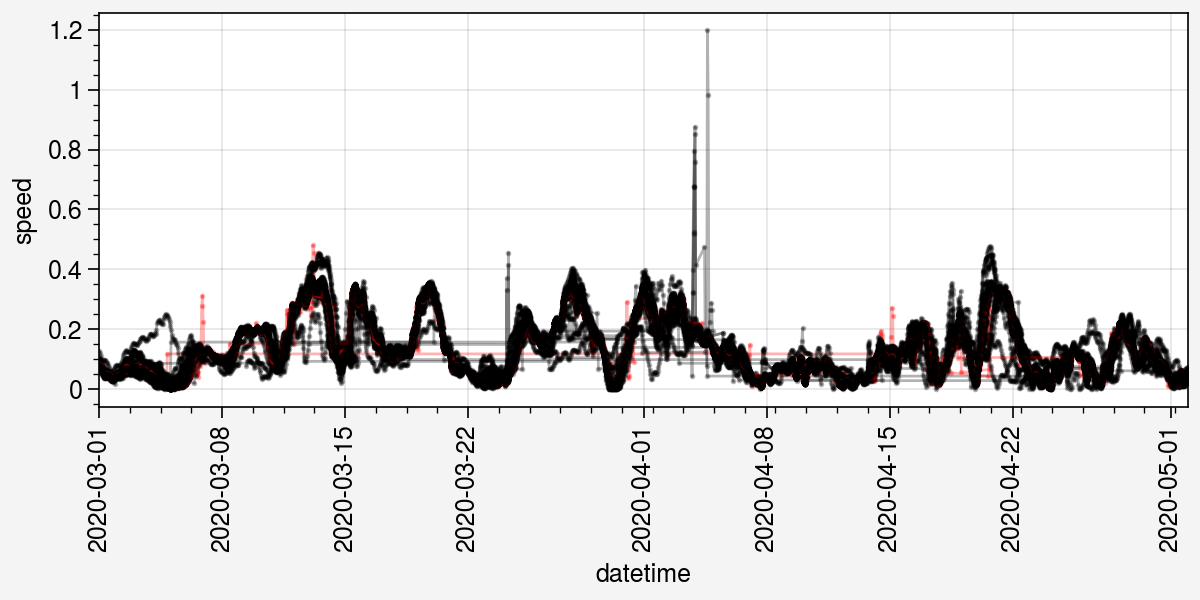

In [220]:
timeslice=slice('2020-03-01', '2020-05-01')
fig, ax = pplt.subplots(width=6, height=3)
for buoy in buoy_data_interp:
    if buoy in fix_buoys:
        c='r'
    else:
        c='k'
    ax.plot(buoy_data_interp[buoy]['speed'].loc[timeslice], lw=1, marker='.', markersize=2,
            alpha=0.3, color=c)

In [97]:
case = 'nov'
timeslice = slice('2019-11-15', '2019-11-20')

case = 'dec'
timeslice = slice('2019-12-15', '2019-12-20')

!mkdir ../sample/$case
for idx in np.arange(0, len(buoys))[::6]:
    fig, ax = pplt.subplots(width=6, height=6, nrows=2)
    for jdx in range(6):
        if idx + jdx < len(buoys):
            buoy = buoys[idx + jdx]
            ax[0].plot(buoy_data_interp[buoy]['speed'].loc[timeslice], marker='', lw=1, label=buoy)
            ax[1].plot(buoy_data[buoy]['speed'].loc[timeslice], marker='', lw=1, label=buoy)    
    ax[0].legend()
    ax[1].legend()
    fig.save('../sample/' + case + '/' + case + '_test_' + buoys[idx] + '-' + buoys[idx + jdx-1] + '.jpg', dpi=150)
    pplt.close(fig)

mkdir: ../sample/dec: File exists


IndexError: list index out of range

In [122]:
# Hypothesis: I'm not catching times when the speed is abnormally low - I was looking for spikes.
# The result of the error is that a spike and a dip is introduced.


In [ ]:
2019P156: too much droppin in may 2020

In [84]:
skip_buoys = ['2019P101']

'2019P101'

In [135]:
clean = reload(clean)


In [197]:
buoy = '2019P156'
buoy_df = buoy_data_interp[buoy].copy()
test = clean.compute_speed(buoy_df, date_index=True, rotate_uv=True, difference='centered')
timeslice=slice('2020-05-15 13:00', '2020-06-18 15:00')
fig, ax = pplt.subplots(width=6, height=3)
#ax.plot(buoy_data_interp['2019P146'].loc[timeslice, 'speed'],  marker='.')
#ax.plot(buoy_data_interp['2019P148'].loc[timeslice, 'speed'], marker='.')
ax.plot(buoy_data_interp[buoy].loc[timeslice, 'speed'], marker='')
ax.plot(test.loc[timeslice, 'speed'], marker='')
ax.plot(buoy_data[buoy].loc[timeslice, 'speed'], marker='.', markersize=3)
ax.format(title=buoy)

In [171]:
fix_buoys = ['2019P101', '2019P137', '2019P138', '2019P139',
'2019P146', '2019P143', '2019P142', '2019P136',
'2019T63', '2019S84', '2019T72', '2020E1', 'ASFSTUCB1',
'2019P187', '2019S81']

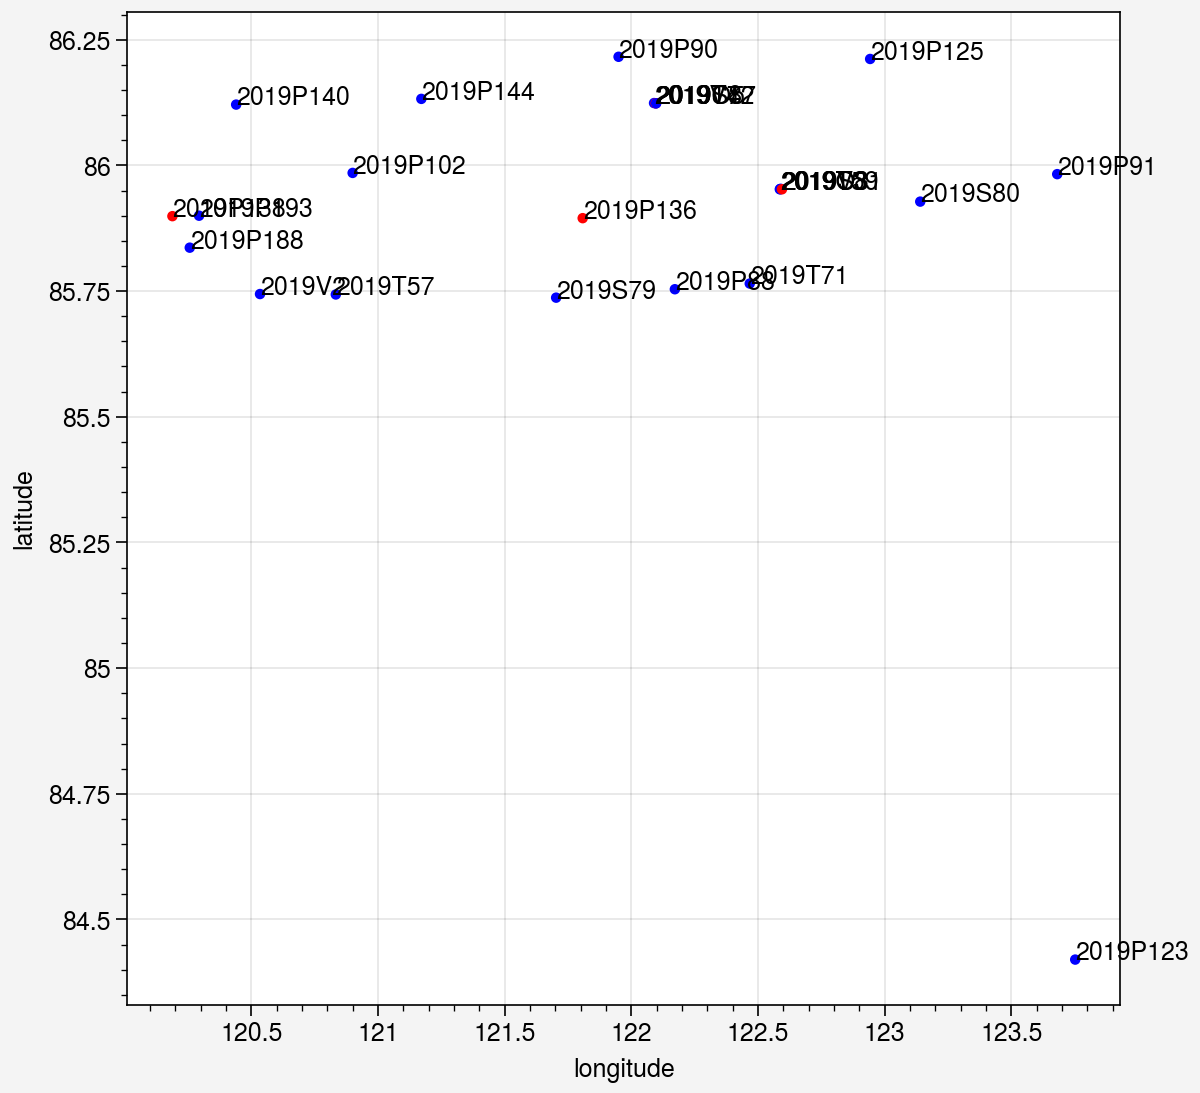

In [212]:
timeslice = slice('2019-11-01', '2019-12-01')
fig, ax = pplt.subplots(width=6)
mosdata = pd.DataFrame({buoy: buoy_data_interp[buoy].loc[timeslice].median() for buoy in buoy_data_interp}).T
mosdata['fix_buoy'] = [x in fix_buoys for x in mosdata.index]
mosdata = mosdata.dropna(subset=['latitude', 'longitude'])
mosdata = mosdata.loc[mosdata.latitude > 80]
mosdata = mosdata.loc[(mosdata.longitude > 120) & (mosdata.longitude < 132.2)]
ax.scatter(mosdata.longitude, mosdata.latitude,
           c=mosdata.fix_buoy.astype(int), cmap='bwr',
           markersize=10)
for x in mosdata.index:

    ax.text(mosdata.loc[x, 'longitude'],
            mosdata.loc[x, 'latitude'], x)

In [ ]:
# Key buoys to repair if possible
# 2019S84, 2019P187, 2019P137, 2019P139, 2019P143, 2019P136, 2019P146
# Less important:
# 2019P138, as long as 2019P193 is functioning (they're close to each other)


<a list of 1 Line2D objects>

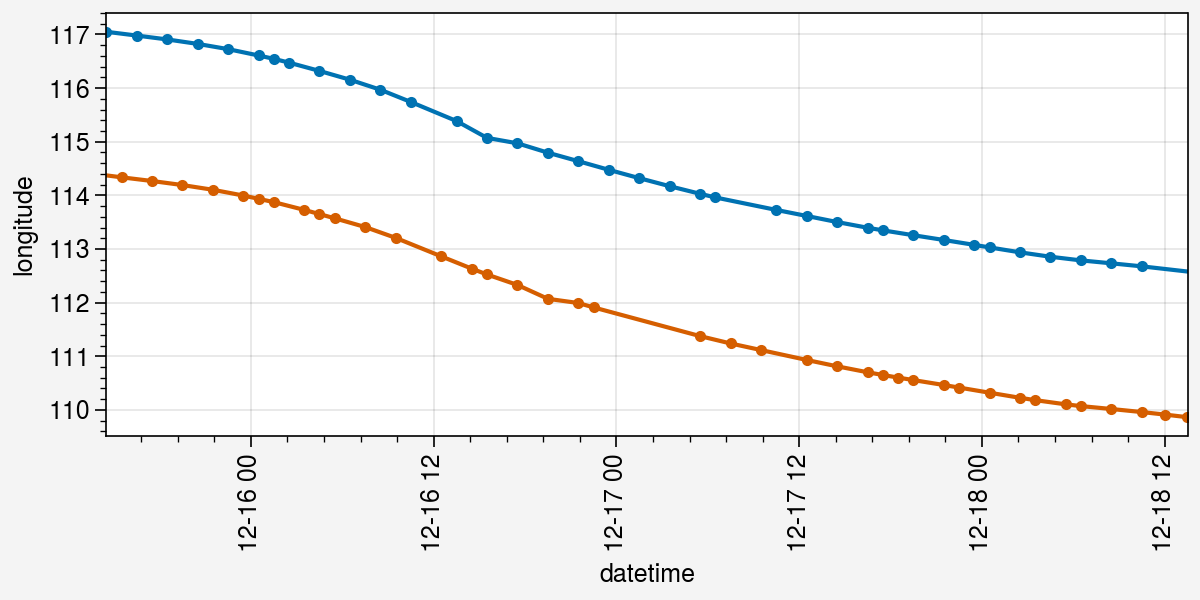

In [80]:
timeslice=slice('2019-12-15 13:00', '2019-12-18 15:00')
fig, ax = pplt.subplots(width=6, height=3)
ax.plot(buoy_data['2019P146'].loc[timeslice, 'longitude'],  marker='.')
ax.plot(buoy_data['2019P148'].loc[timeslice, 'longitude'], marker='.')
#ax.plot(buoy_data_interp['2019P146'].loc[timeslice, 'latitude'],  marker='.')
#ax.plot(buoy_data_interp['2019P148'].loc[timeslice, 'latitude'], marker='.')

In [15]:
for buoy in buoy_data:
    buoy_data[buoy]['flag'] = buoy_data[buoy].flag_date | buoy_data[buoy].flag_position | buoy_data[buoy].flag_gaps

In [17]:
# Drift speed:
for buoy in buoy_data:
    buoy_df = buoy_data[buoy].where(buoy_data[buoy]['flag'] == 0)
    w_speed = clean.compute_speed(buoy_df.dropna().copy(), date_index=True, difference='forward')
    buoy_df.loc[w_speed.index, 'speed'] = w_speed['speed'].copy()
    buoy_df.loc[w_speed.index, 'x'] = w_speed['x'].copy()    
    buoy_df.loc[w_speed.index, 'y'] = w_speed['y'].copy()        
    buoy_data[buoy] = buoy_df

Because the buoys vary in their time resolution and in the inherent noise, naive screening for fixed velocity thresholds will not identify most spikes in estimated velocities. Furthermore, data at very high resolution (e.g. < 15min) provide noisy estimates of position, because the inherent error in position of between 10-100 m is close to the magnitude of position change. For example, if ice is moving at 0.5 m/s, it moves 450 meters in between measurements. Estimated difference in position will be between 430 and 470 in the best case scenario, and between 350 and 550 in the worst case. For ice moving more slowly, as it often is, the result of the noise could be that the uncertainty in position is larger than the position change. Per Dierking et al. 2022,
$$\sigma^2_u = \frac{1}{\Delta t^2}\sigma_{x}^2$$
With smaller time steps, the uncertainty in velocity is larger (in a sense).

In [336]:
for buoy in buoy_data:
    buoy_data[buoy]['fwd_disp'] = np.sqrt(
        (buoy_data[buoy]['x'].shift(-1) - buoy_data[buoy]['x'])**2 +\
        (buoy_data[buoy]['y'].shift(-1) - buoy_data[buoy]['y'])**2)
    buoy_data[buoy]['bwd_disp'] = np.sqrt(
        (buoy_data[buoy]['x'] - buoy_data[buoy]['x'].shift(1))**2 +\
        (buoy_data[buoy]['y'] - buoy_data[buoy]['y'].shift(1))**2)

    date = buoy_data[buoy].index.to_series()
    time_till_next = date.shift(-1) - date
    time_since_last = date - date.shift(1)

    buoy_data[buoy]['fwd_endpoint'] = time_till_next.dt.total_seconds() > \
            2*(time_till_next.dt.total_seconds()).rolling(7, ).median()
    buoy_data[buoy]['bwd_endpoint'] = time_since_last.dt.total_seconds() > \
            2*(time_since_last.dt.total_seconds()).rolling(7, ).median()

In [291]:
test_df = pd.DataFrame(
    [['2019R9', '2020-04-23 11:01:09', 'check_speed', True],
     ['2019R9', '2020-05-17 01:02:20', 'check_speed', True],
     ['2020P171','2020-12-13 00:04:00', 'check_speed', True],
     ['2020P171', '2021-01-08 20:04:01', 'check_speed', True],
     ['2020P171', '2021-01-08 16:04:02', 'check_speed', True],
     ['2019P178', '2021-01-21 13:00:28', 'check_speed', True],
     ['2019P142', '2020-04-04 14:30:00', 'check_speed', True],
     ['2019P142', '2020-05-25 01:00:00', 'check_speed', True], 
      ['2019P142', '2020-07-23 00:59:59', 'check_speed', True]],
    columns=['buoy_id', 'date', 'check_var', 'true_val'])
test_df['date'] = pd.to_datetime(test_df['date'])

In [18]:
for buoy in buoy_data:
    x = buoy_data[buoy].where(buoy_data[buoy].flag != 1)['x']
    anomalyx = x - x.rolling(3, center=True, min_periods=3).median()
    buoy_data[buoy]['x_anom'] = anomalyx
    y = buoy_data[buoy].where(buoy_data[buoy].flag != 1)['y']
    anomalyy = y - y.rolling(3, center=True, min_periods=3).median()
    buoy_data[buoy]['y_anom'] = anomalyy
    buoy_data[buoy]['anom_dist'] = np.sqrt(anomalyx**2 + anomalyy**2)

In [195]:
def spline_check_v2(buoy_df, anom_thresh, df):
    anom_x = buoy_data[buoy].x_anom
    anom_y = buoy_data[buoy].y_anom
    anom = np.sqrt(anom_x**2 + anom_y**2)
    if 'flag_position_spline' not in buoy_df.columns:
        buoy_df['flag_position_spline'] = 0

    for date in anom[anom > anom_thresh].index:
        test = clean.test_point(date, buoy_data[buoy],
                                xvar='x', yvar='y', df=df, fit_window='24H', sigma=6)['flag']
        if np.any(test):
            buoy_df.loc[test[test].index, 'flag_position_spline'] = 1
    
    return buoy_df

In [155]:
def calc_speed_for_outlier_check(buoy_df, date_index=True):
    """Computes a measure of speed adapted for flagging bad data.
    Since most of the buoy data has some gaps, the algorithm needs 
    to calculate speed different at the start and end of regular observations
    versus in the middle of regular observations. It does this by looking
    at delta_t_prior and delta_t_post, the times since last and till
    next. If both are approximately the same size, then the returned 
    speed is the minimum of the forward and the backward difference estimates
    of velocity. If delta_t_prior << delta_t_post, only the backward difference is
    used. Otherwise the forward difference is used."""

    date_index=True
    buoy_df = buoy_df.dropna(subset=['latitude', 'longitude']).copy()
  
    if date_index:
        date = pd.Series(pd.to_datetime(buoy_df.index.values).round('1min'),
                         index=buoy_df.index)
    else:
        date = pd.to_datetime(buoy_df.date).round('1min')

    delta_t_next = date.shift(-1) - date
    delta_t_prior = date - date.shift(1)

    fwd_speed = clean.compute_speed(buoy_df.copy(), date_index=True, difference='forward')['speed']  
    bwd_speed = clean.compute_speed(buoy_df.copy(), date_index=True, difference='backward')['speed']

    min_dt = pd.DataFrame({'dtp': delta_t_prior, 'dtn': delta_t_next}).min(axis=1)

    # bwd endpoint means the next expected obs is missing: last data before gap
    bwd_endpoint = (delta_t_prior < delta_t_next) & (np.abs(delta_t_prior - delta_t_next) > 2*min_dt)
    fwd_endpoint = (delta_t_prior > delta_t_next) & (np.abs(delta_t_prior - delta_t_next) > 2*min_dt)

    buoy_df['speed'] = pd.DataFrame({'bwd': bwd_speed, 'fwd': fwd_speed}).min(axis=1)
    buoy_df.loc[fwd_endpoint, 'speed'] = fwd_speed.loc[fwd_endpoint]
    buoy_df.loc[bwd_endpoint, 'speed'] = bwd_speed.loc[bwd_endpoint]
    
    return buoy_df

In [369]:
def identify_outliers(buoy_df, error_threshold, fit_margin, sigma=6, detailed_return=False):
    """Flags data that are likely outliers based on three criteria:
    1. Data have anom_dist > sigma*anom_std
    2. anom_dist is a local max
    3. speed is a local max
    4. Interpolation error is greater than the error_threshold
    Returns a boolean series of the same length as buoy_df, unless
    detailed_return=True, in which case a dataframe with the tested values is returned."""

    def est_middle(date, data, xvar, yvar):
        from scipy.interpolate import interp1d
        """Similar to the savgol filter, estimate the value at date with a polynomial fit.
        """
        t0 = (data.drop(date).index - data.index[0]).total_seconds()
        t1 = (date - data.index[0]).total_seconds()

        X = data.drop(date).loc[:,[xvar, yvar]].T
        return interp1d(t0, X.values, bounds_error=False, kind='cubic')(t1).T
   
    fit_margin = pd.to_timedelta(fit_margin)
    #anom_std = np.sqrt(2 * buoy_df['anom_dist'].where(buoy_df['anom_dist'] > 0).mean())
    anom_std = np.sqrt(2 * buoy_df['anom_dist'].where(buoy_df['anom_dist'] > 0).mean())
    test_dates = buoy_df[['anom_dist', 'speed']][buoy_df['anom_dist'] > sigma*anom_std]
    test_dates = test_dates.sort_values('anom_dist')[::-1]

    #anom_above_threshold = buoy_df['anom_dist'] > (buoy_df.where(buoy_df.anom_dist > 0)['anom_dist']).rolling('30D', center=True).median()*2
    #speed_above_threshold = buoy_df['speed'] > buoy_df['speed'].rolling('30D', center=True).median()*2
    anom_local_max = buoy_df['anom_dist'] == buoy_df['anom_dist'].rolling(fit_margin, center=True).max()
    speed_local_max = buoy_df['speed'] == buoy_df['speed'].rolling(fit_margin, center=True).max()

    test_dates['anom_max'] = anom_local_max.loc[test_dates.index]
    test_dates['speed_max'] = speed_local_max.loc[test_dates.index]
    #canidates = (test_dates.anom_max & test_dates.speed_max).index
    test_dates['interp_error'] = np.nan

    for date in test_dates.index:
        date=pd.to_datetime(date)
        x0 = buoy_df.loc[date, 'x']
        y0 = buoy_df.loc[date, 'y']
        x1, y1 = est_middle(date, buoy_df.loc[slice(date-fit_margin, date+fit_margin)], 'x', 'y') 
        test_dates.loc[date, 'interp_error'] = np.sqrt((x0-x1)**2 + (y0-y1)**2)

    test_dates['exceeds_threshold'] = test_dates['interp_error'] > error_thresh
    test_dates['decision'] = (test_dates.anom_max & test_dates.speed_max) & test_dates.exceeds_threshold

    if detailed_return:
        return test_dates

    else:
        flag = pd.Series(dtype=bool, index=buoy_df.index)
        flag[test_dates['decision'].index] = True
        return flag

In [372]:

buoy = '2019O1'
buoy_df = buoy_data[buoy].copy()
buoy_df = calc_speed_for_outlier_check(buoy_df, date_index=True)
error_thresh = data_thresh.groupby('freq').quantile(0.9).loc[data_thresh.loc[buoy, 'freq']].values[0]


flag = identify_outliers(buoy_df, error_thresh, fit_margin='12H', sigma=6, detailed_return=False)
outliers = identify_outliers(buoy_df, error_thresh, fit_margin='12H', sigma=6, detailed_return=True)
outliers.loc[outliers.decision]

anom_dist     speed  anom_max  speed_max  interp_error  \
datetime                                                                       
2020-02-09 17:00:00  145.576593  0.283768      True       True    189.443471   
2019-10-05 06:00:00   55.817117  0.116493      True       True     79.299327   
2019-12-14 00:50:00   46.681790  0.082313      True       True     49.458549   
2020-03-22 17:20:01   29.563803  0.059591      True       True     41.877571   
2020-02-20 02:20:01   24.805255  0.211816      True       True     72.074188   
2020-07-25 04:40:01   22.604462  0.037727      True       True     47.523197   
2019-12-10 05:40:00   11.132817  0.145212      True       True     27.796640   

                     exceeds_threshold  decision  
datetime                                          
2020-02-09 17:00:00               True      True  
2019-10-05 06:00:00               True      True  
2019-12-14 00:50:00               True      True  
2020-03-22 17:20:01               True      True  
2020-02-20 02:20:01               True      True  
2020-07-25 04:40:01               True      True  
2019-12-10 05:40:00               True      True

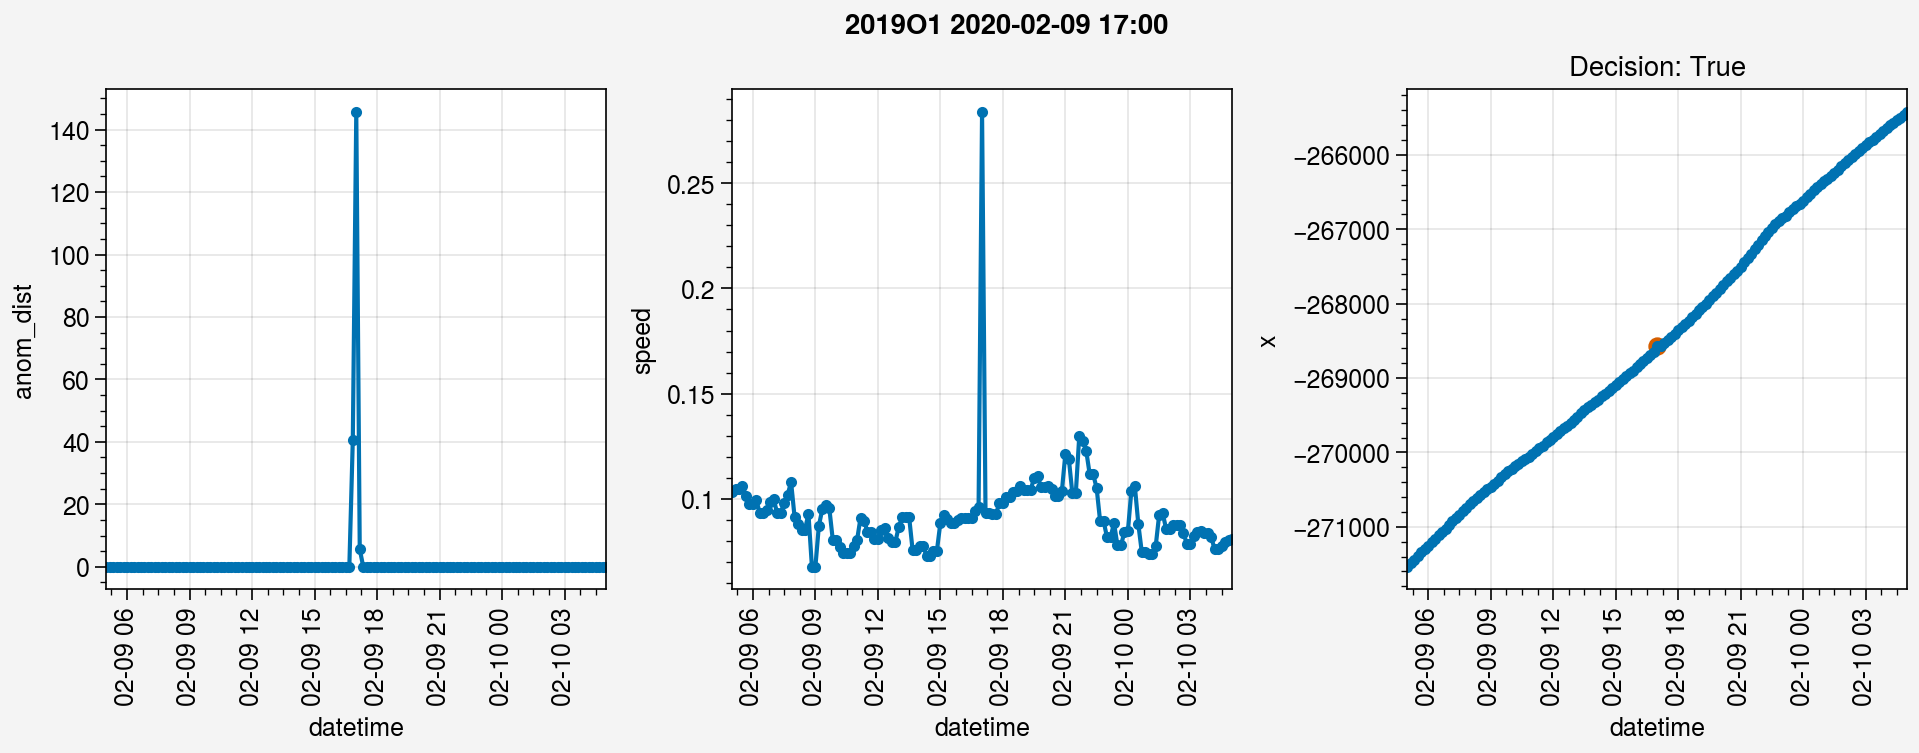

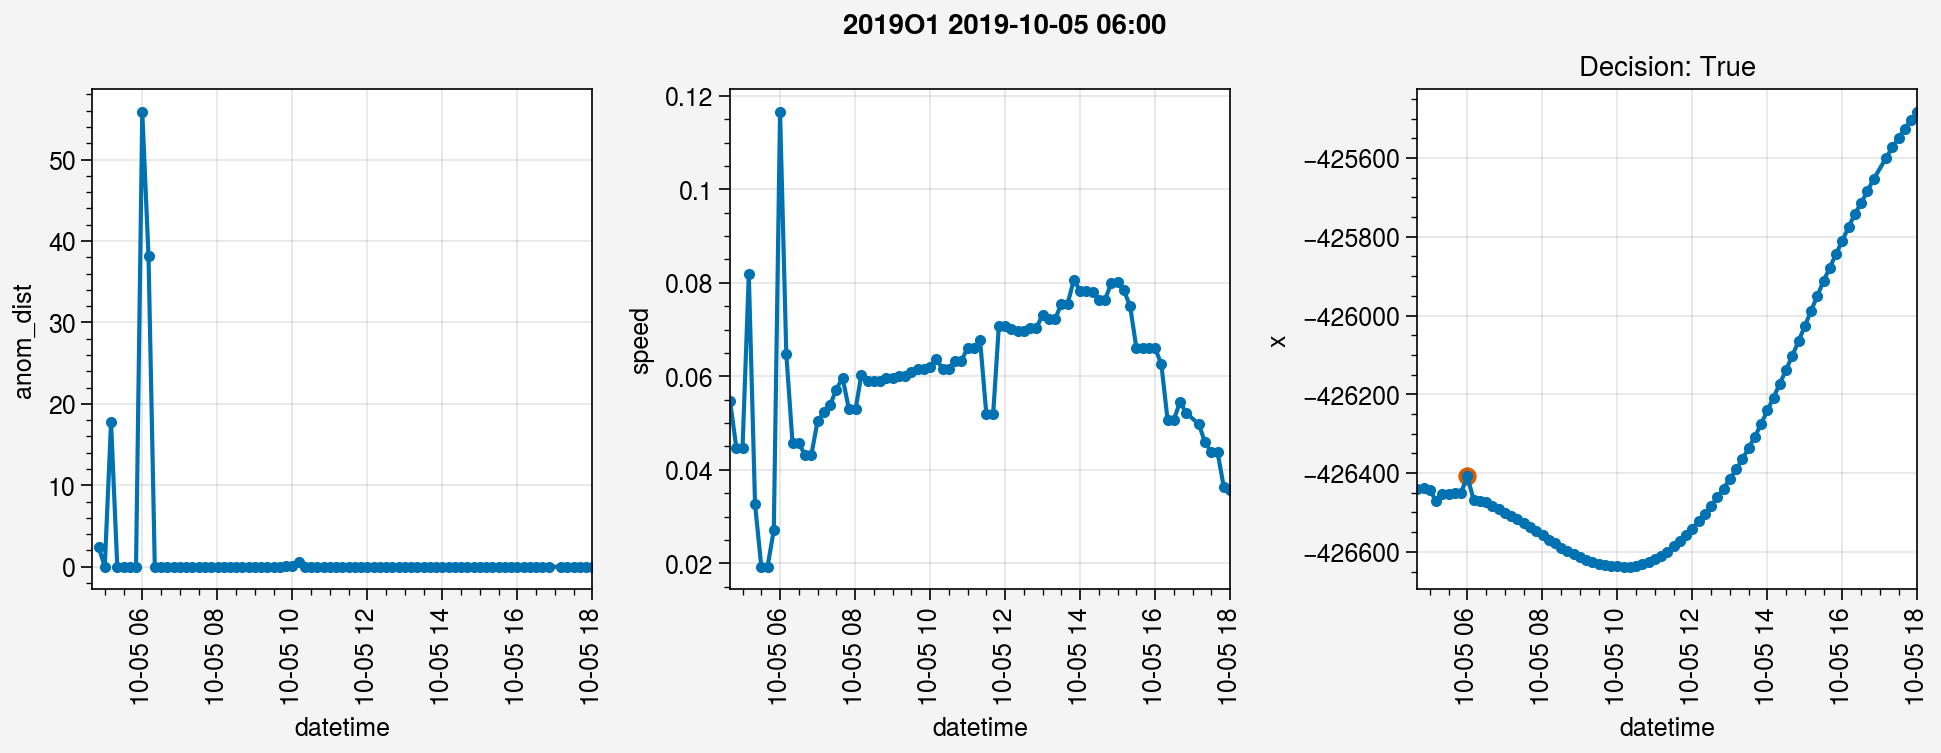

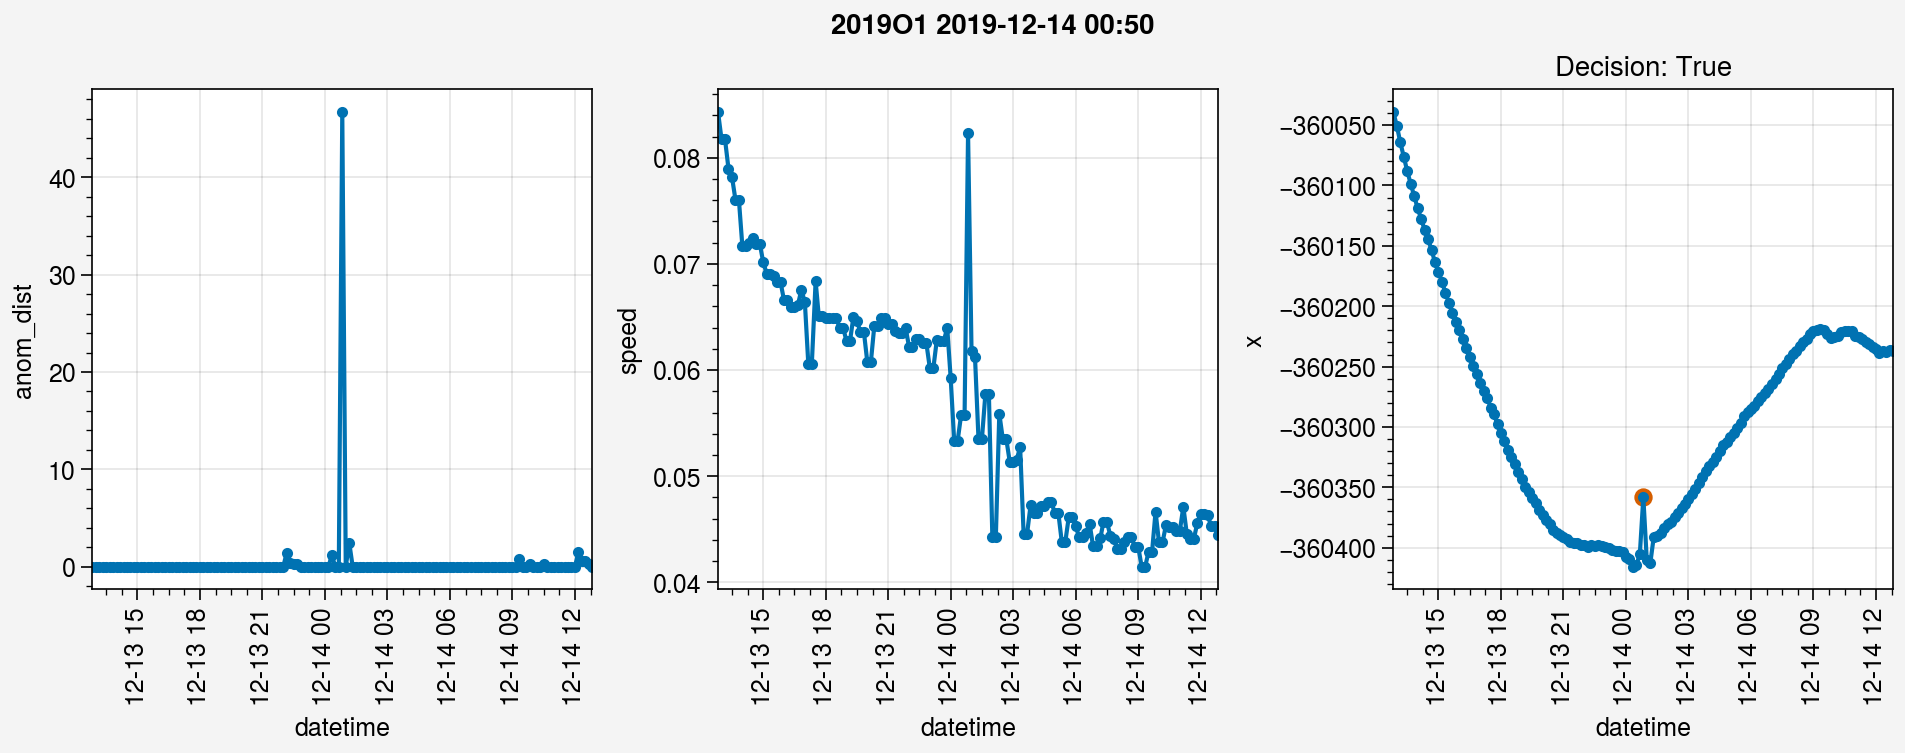

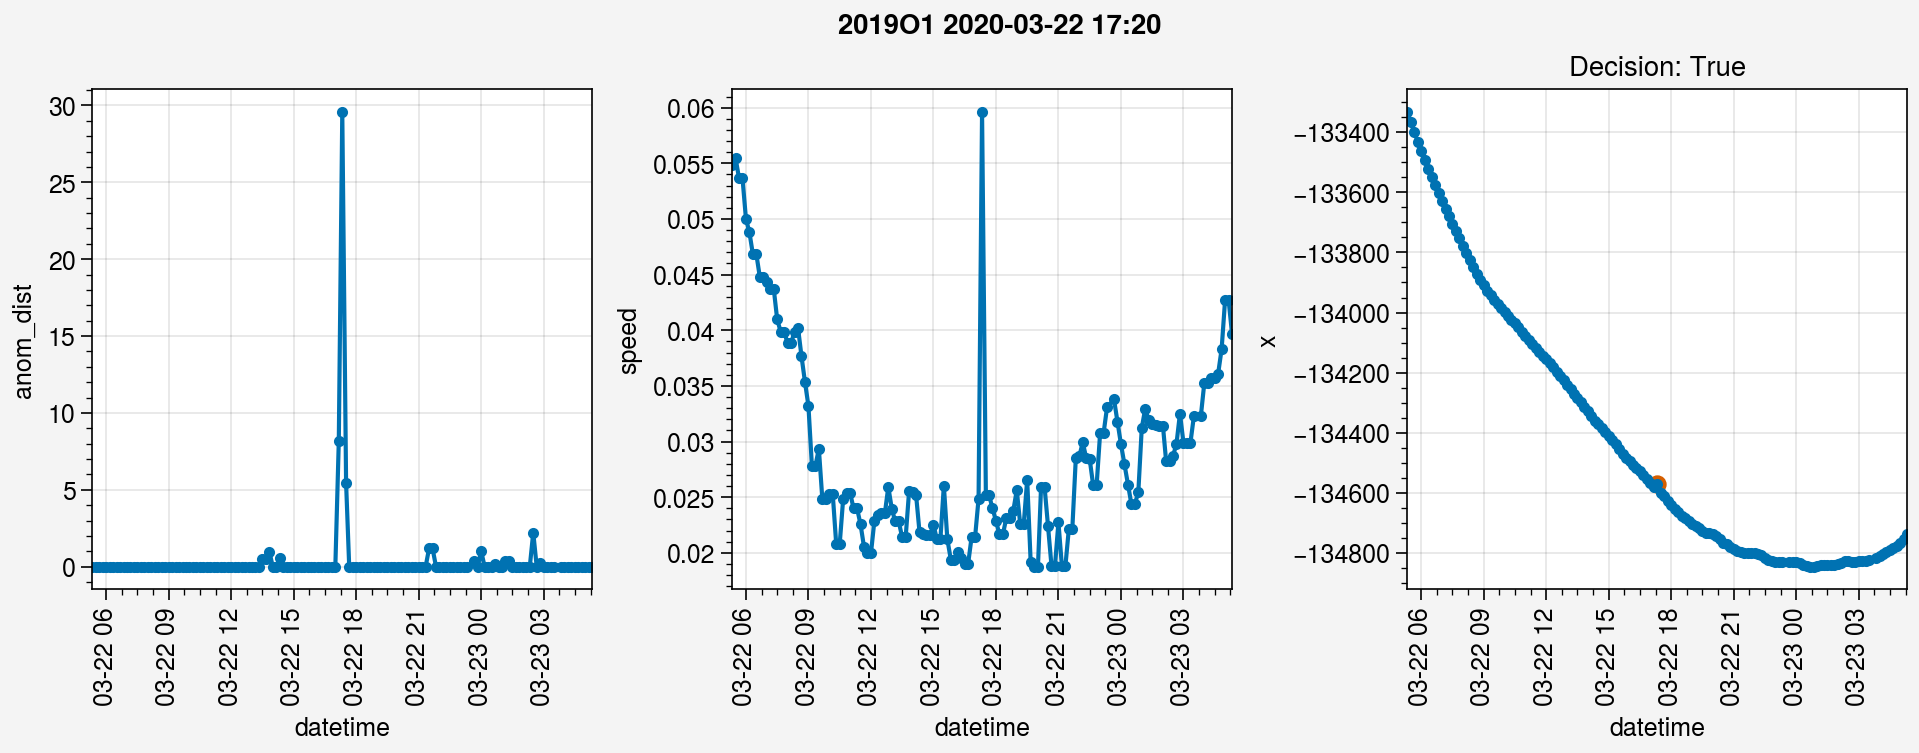

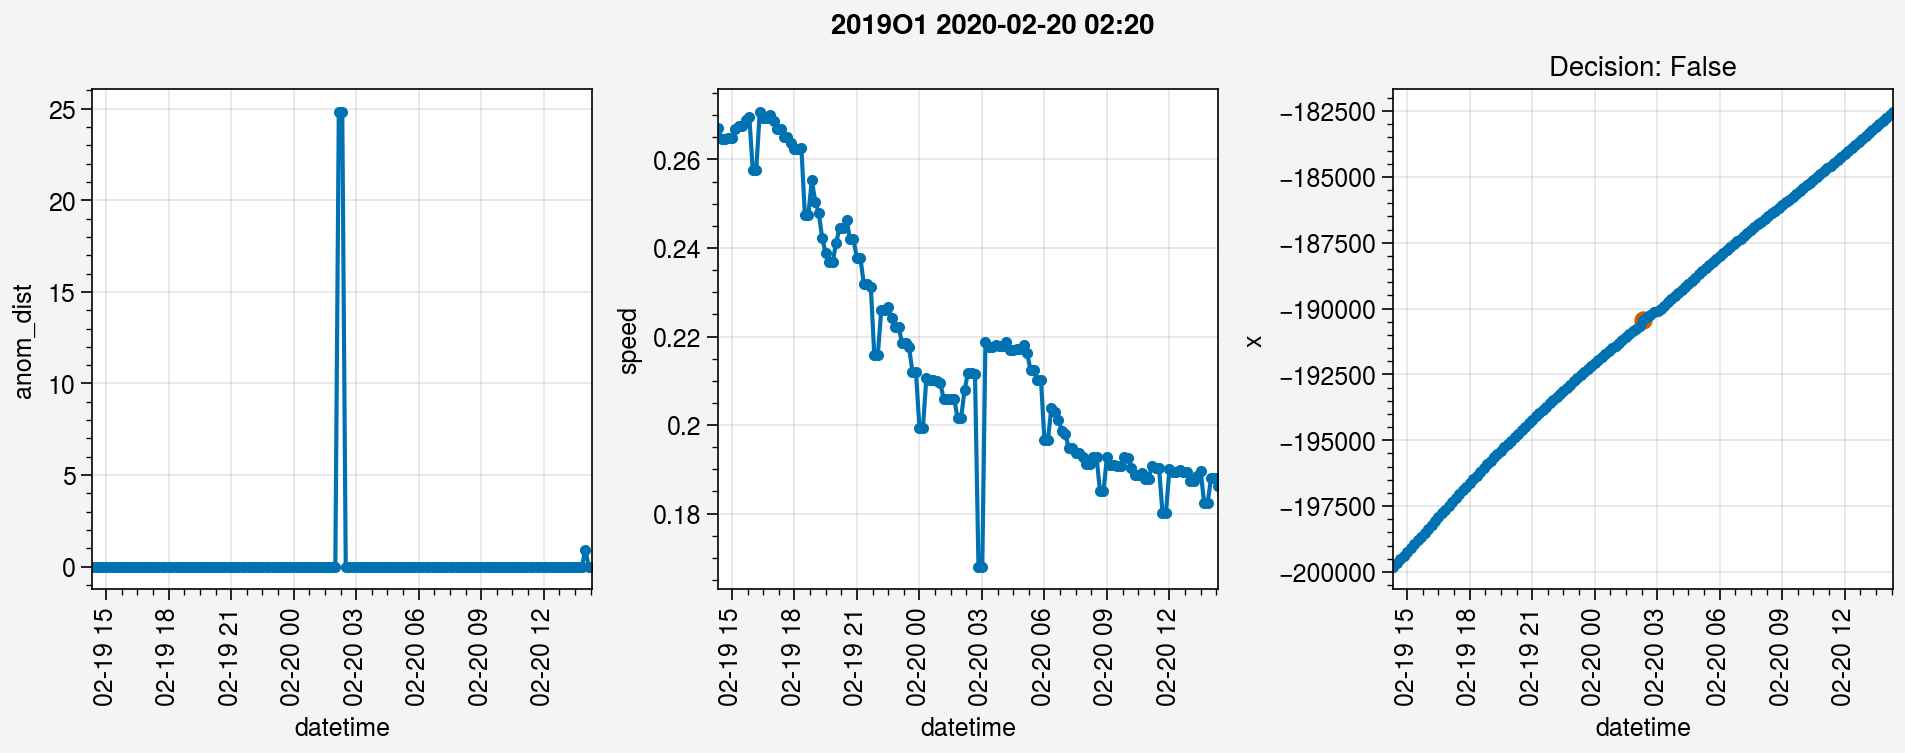

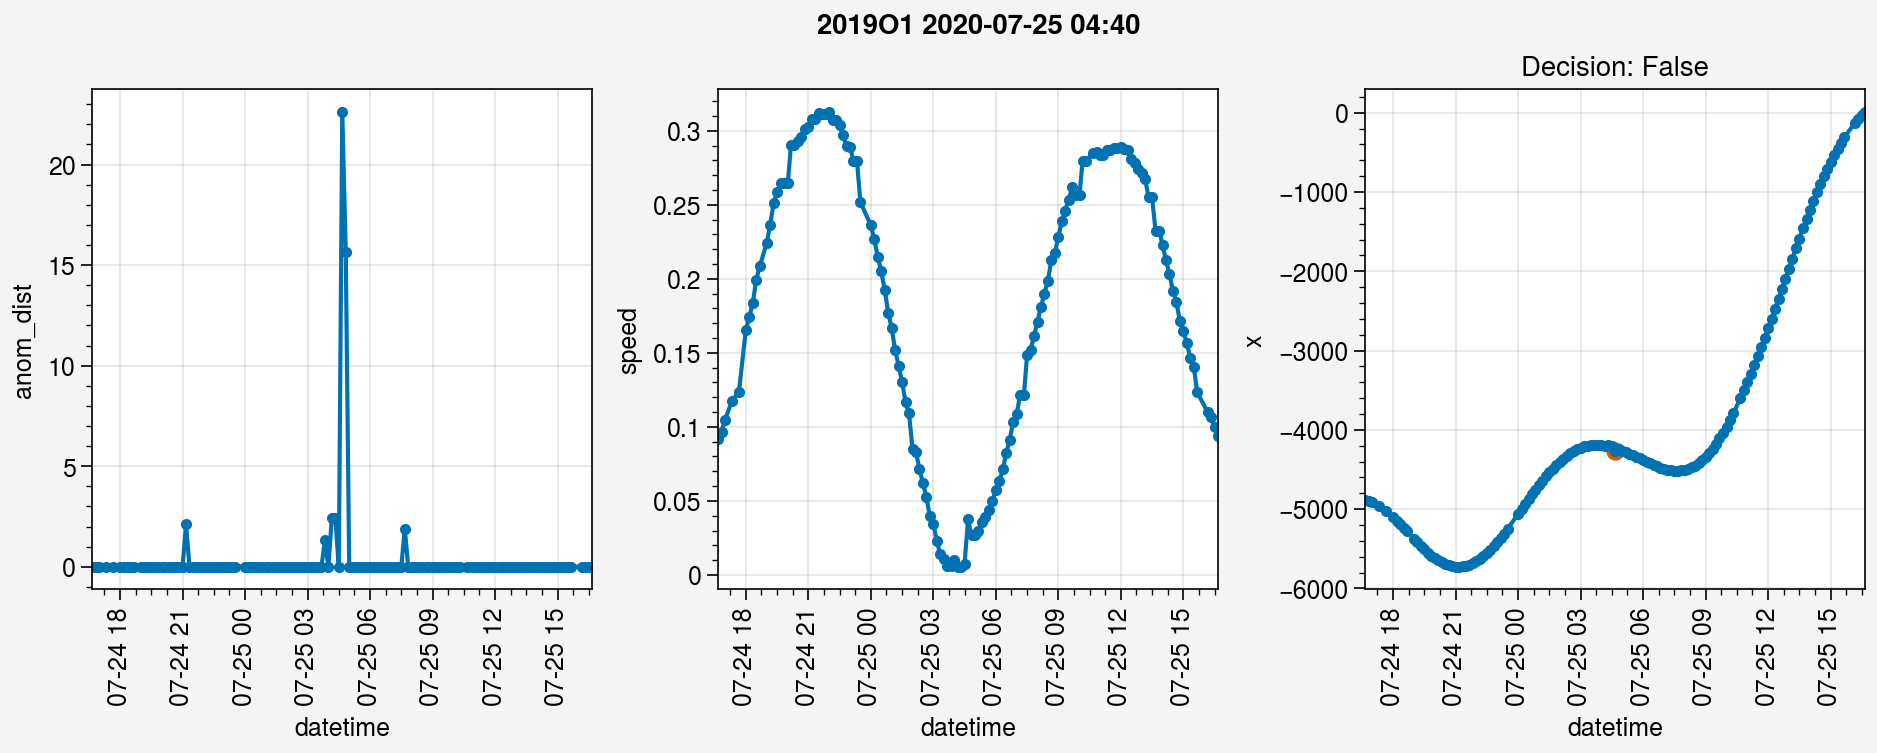

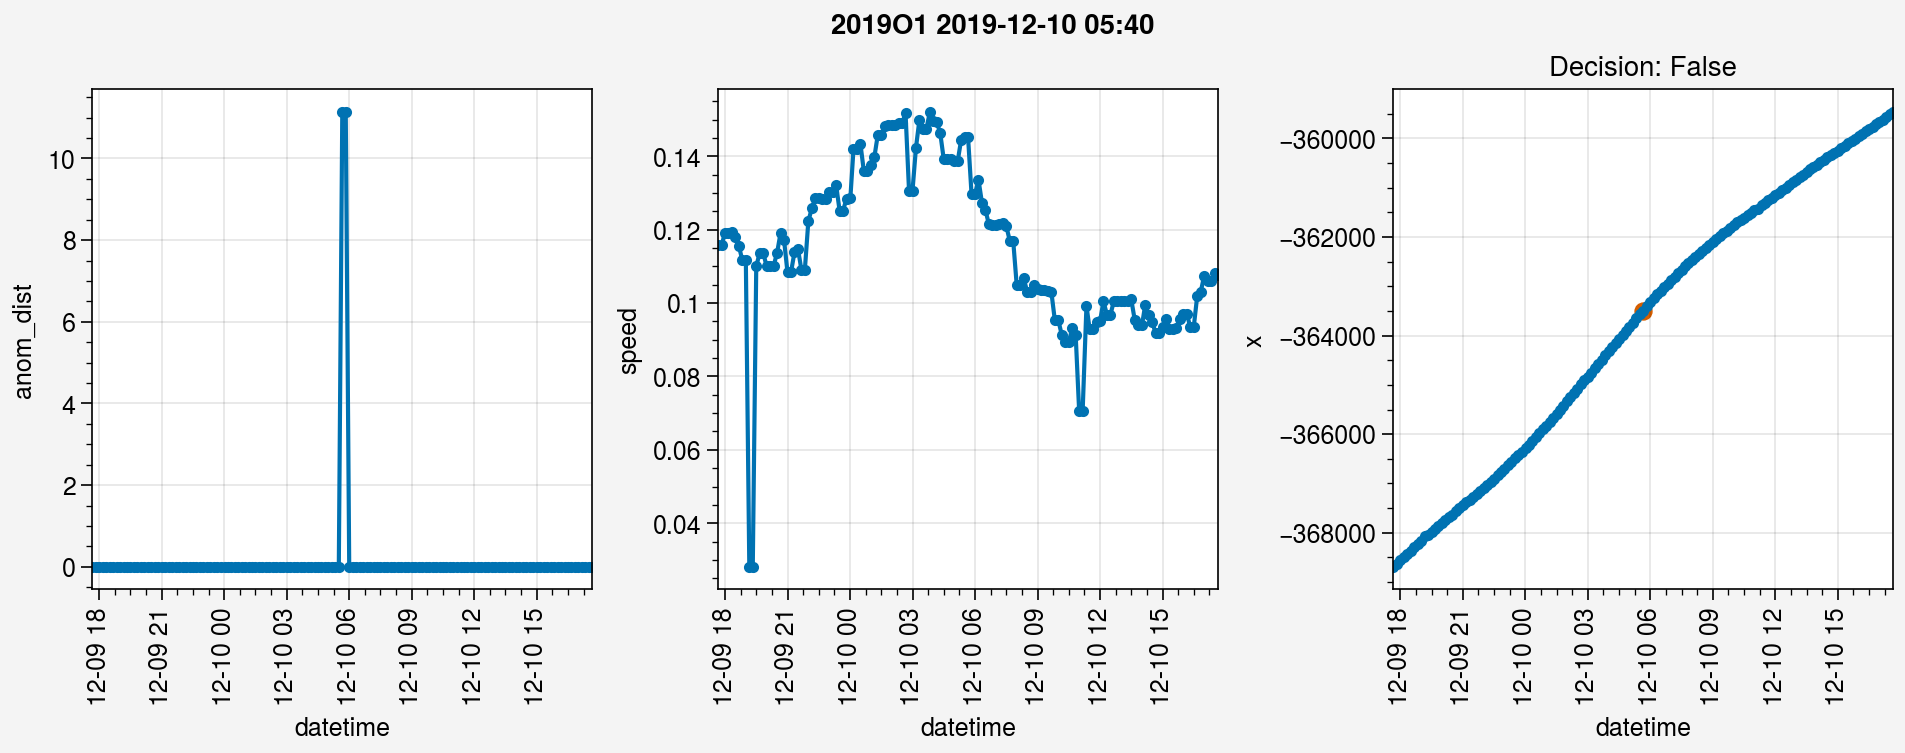

In [373]:
subset = outliers.decision # replace if checking other combinations of anom max, speed max, exceed thresh
for date in outliers.loc[subset].index:
    fig, ax= pplt.subplots(ncols=3, share=False)
    ax[0].plot(buoy_df.loc[slice(date-margin, date+margin), 'anom_dist'], marker='.')
    ax[1].plot(buoy_df.loc[slice(date-margin, date+margin), 'speed'], marker='.')
    ax[2].plot(buoy_df.loc[slice(date-margin, date+margin), 'x'], marker='.')
    ax.format(suptitle=buoy + ' ' + date.strftime('%Y-%m-%d %H:%M'))
    ax[2].format(title='Decision: ' + str(test_dates.loc[date, 'decision']))
    ax[2].scatter(date, buoy_df.loc[date, 'x'])

Process for identifying bad datapoints. A statistical model must be built. But this model must not be so stringent as to remove local extrema in the quest to remove single outlier points. It must also be flexible enough to handle data that have irregular reporting.

Assumptions  
At an outlier point,
- anom_dist will be a local maximum
- speed will be a local maximum
- replacing x,y with a cubic spline interpolatant results in a large change in position

To estimate the uncertainty in the cubic spline interpolant, for each buoy, I randomly select 1000 dates, calculate the spline interpolant, and measure the residual. For the buoys with less than 1000 observations, I use half the data. There's a clear (and expected) relationship between the 99th percentile of the error and the buoy frequency - the errors are larger with larger data gaps. It's for this reason that a single threshold doesn't work for the full dataset. 

TBD: identify periods with different frequencies, and apply the outlier finder individually on each.

1. Calculate anom_dist and sigma
    1. sigma estimated as sqrt of 2$*$mean(anom_dist s.t. anom_dist > 0)
    2. tbd: test assumption that the positive values of anom_dist are chi2 distributed
2. Beginning with max(anom_dist):
    1. Check if speed is a local maximum
    2. Calculate the difference between xhat, yhat and x, y
    3. If dist > threshold given the frequency, flag the point.
3. Continue until each data point with anom_dist $> 6*$sigma has been tested.

Where I left off: I'm evaluating whether it's necessary to check the max anom and max speed. It is doing pretty well for P142. Need to check for a sampling of other buoys too.

In [244]:
data_thresh = pd.DataFrame({'freq': buoy_freq, 'error_thresh': np.nan})

In [250]:
# What is the uncertainty in the local estimate?
for buoy in buoy_data:
    buoy_df = buoy_data[buoy].copy()
    n = np.min([int(len(buoy_df)/2), 1000])
    date_sample = np.random.choice(buoy_df.index, replace=False, size=n)
    error = []
    for date in date_sample:
        x0 = buoy_df.loc[date, 'x']
        y0 = buoy_df.loc[date, 'y']
        try:
            x1, y1 = est_middle(date, buoy_df.loc[slice(date-margin, date+margin)], 'x', 'y')        
            error.append(np.sqrt((x0-x1)**2 + (y0-y1)**2))
        except:
            error.append(np.nan)
    sample = pd.Series(error, index=date_sample).sort_index()
    data_thresh.loc[buoy, 'error_thresh'] = sample.quantile(0.99)
    print(buoy, sample.quantile(0.99))

2019R9 148.41586684376284
2019P142 302.0211527863129
2019T66 22.207923676085155
2020P164 40.433616455407005
2019R8 65.95938702276517
2020P170 40.8430524403657
2019P203 31.613506926123485
2019P91 10.574576915298952
2020P176 52.296893013615495
2019P151 263.29393785425793
2020P171 168.2211102155484
ASFS50UCB4 2.3547987607530003
2020P162 33.275683585973546
2020P233 39.451871455217685
2019O4 12.934668586681514
2020S97 50.76327198566539
2019T67 13.130016015169748
2019P143 256.56684534390166
2019S87 43.44573880470624
2019P137 540.0298811134052
ASFS30UCB5 3.280438382741691
2020P163 33.40991361801446
2019O7 9.604232999635036
2020T84 139.6205128413331
2020P178 28.274064089900737
ASFS30UCB4 1.9035758427586464
2020P174 32.77559076748309
2020T81 146.21017292903164
2019S95 20.041340909064857
2020R10 53.990866879732636
2019S94 43.01533111084765
2019O2 10.017825427561299
2019T70 139.57686791716677
2019P153 116.7193640116327
2020P230 208.88664880954283
2020P236 47.05422634728306
2019O3 8.24613876744490

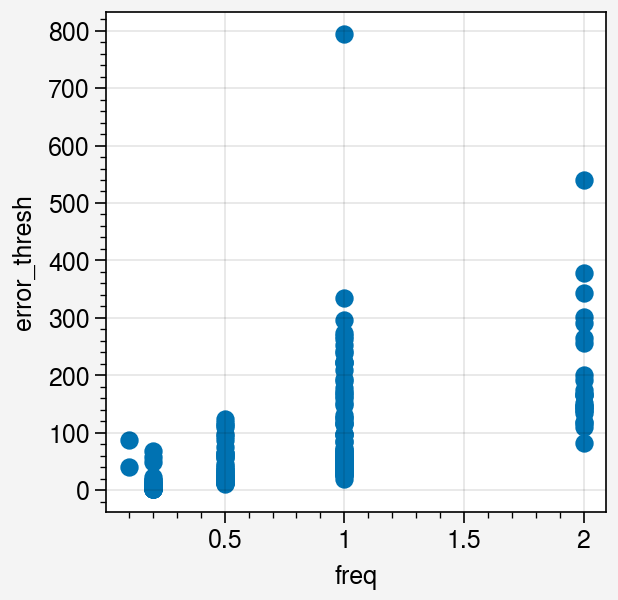

In [251]:
fig, ax = pplt.subplots()
ax.scatter(data_thresh.freq, data_thresh.error_thresh)

In [252]:
data_thresh.to_csv('../data/error_estimate_cubic_splines.csv')

In [254]:
data_thresh.idxmax()

freq            2019P142
error_thresh    2019P139
dtype: object

In [81]:
est_middle(date, buoy_df.loc[slice(date-margin, date+margin)], 'x', 'y')

array([-21322.87183869, 317859.8201724 ])

In [82]:
margin = pd.to_timedelta('24H')
test = [est_middle(date, buoy_df.loc[slice(date-margin, date+margin)], 'x', 'y') 
 for date in buoy_df.loc[timeslice].index]
test = pd.DataFrame(test, columns=['x', 'y'], index=buoy_df.loc[timeslice].index)

<a list of 1 Line2D objects>

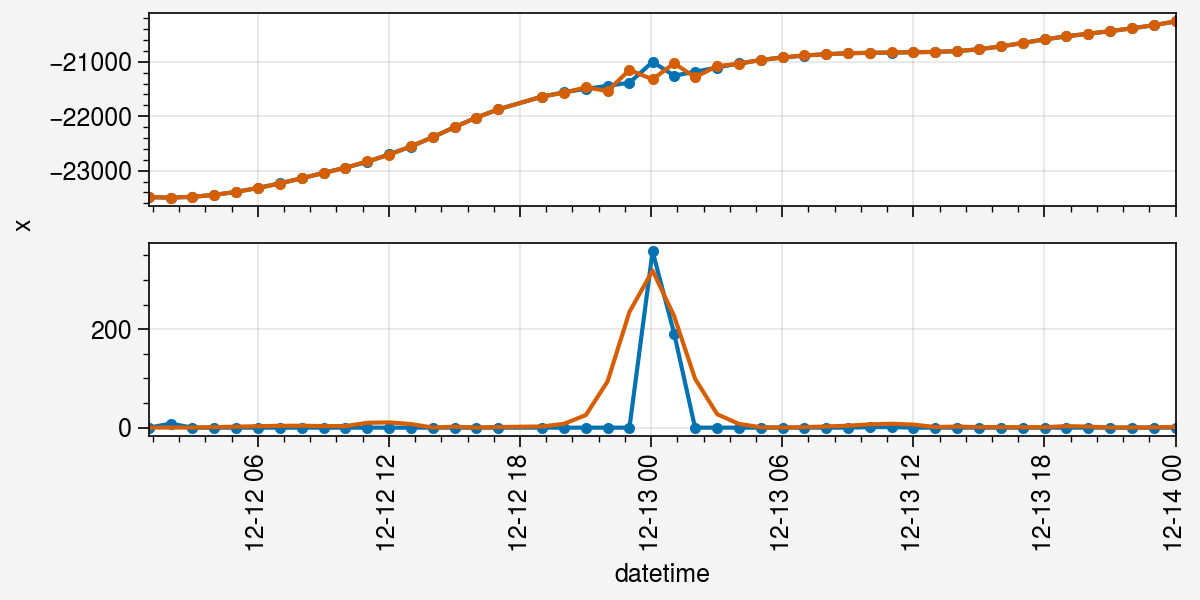

In [83]:
#timeslice = slice('2020-01-30', '2020-02-02')
fig, ax = pplt.subplots(width=6, height=3, nrows=2)
ax[0].plot(buoy_df.loc[timeslice]['x'], marker='.')
ax[0].plot(test['x'], marker='.')
ax[1].plot(buoy_df.loc[timeslice]['anom_dist'], marker='.')
ax[1].plot(np.abs(buoy_df.loc[timeslice]['x'] - test['x']))

In [ ]:
# Identify potential error points


In [219]:
dates = buoy_df.index[buoy_df.flag_position_spline==1][0:10]

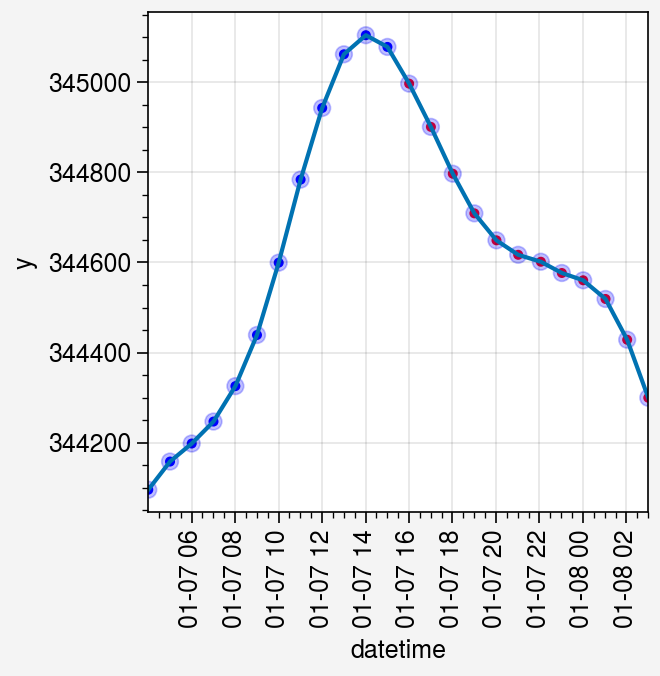

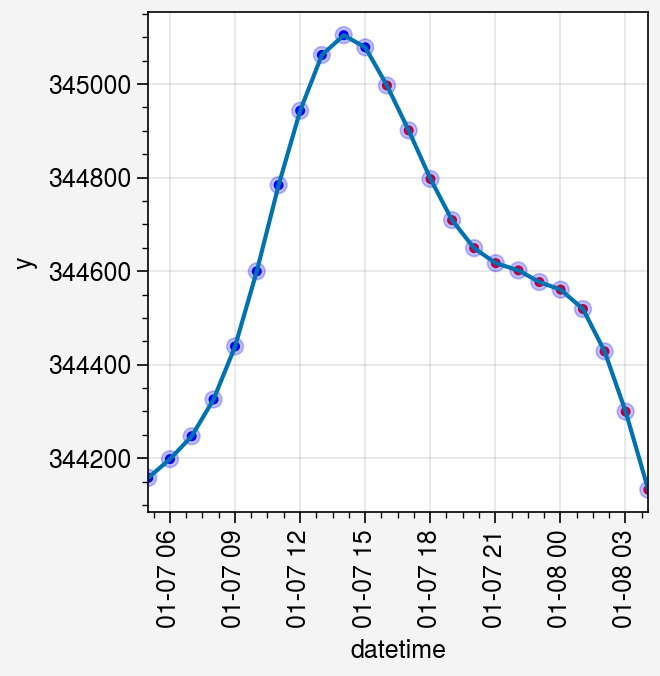

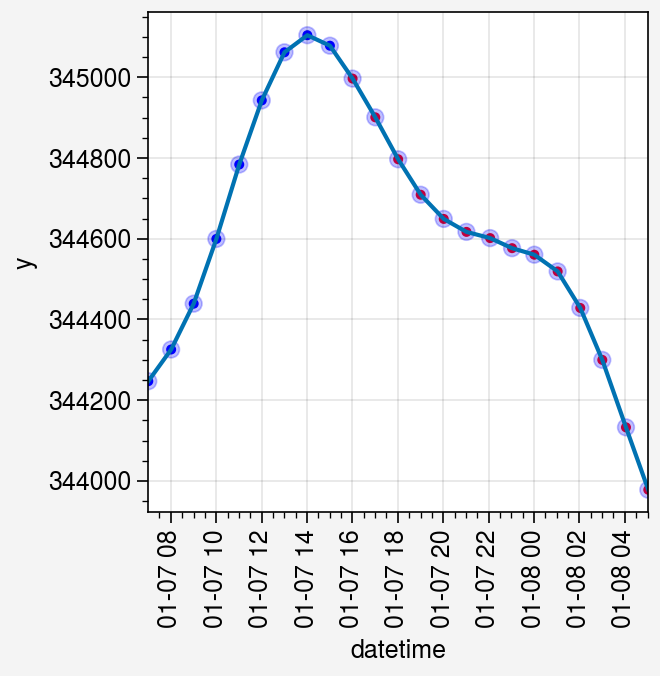

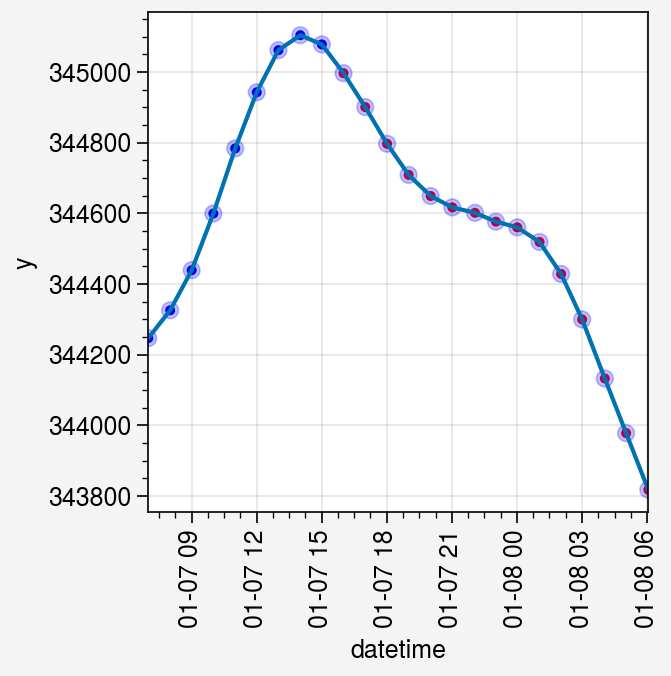

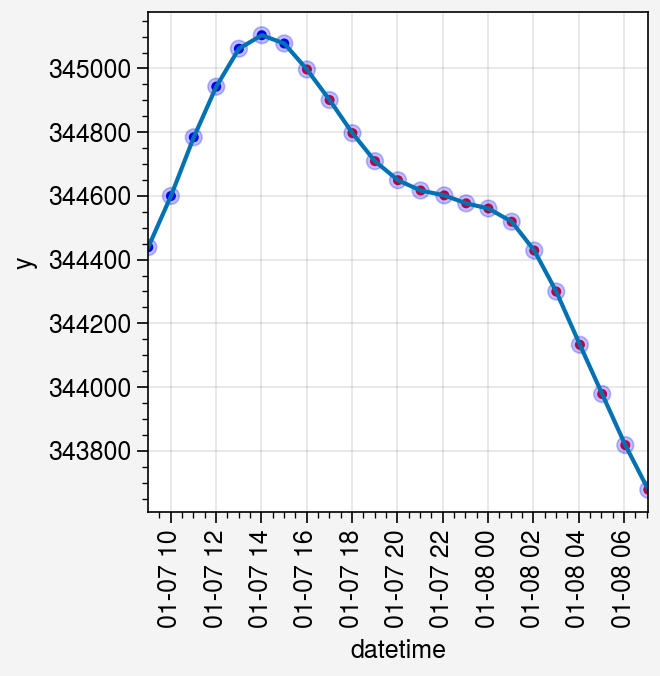

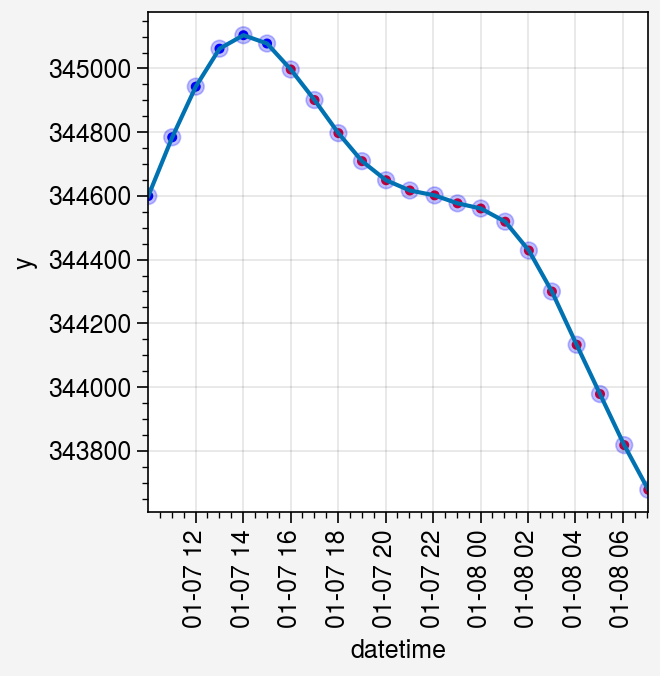

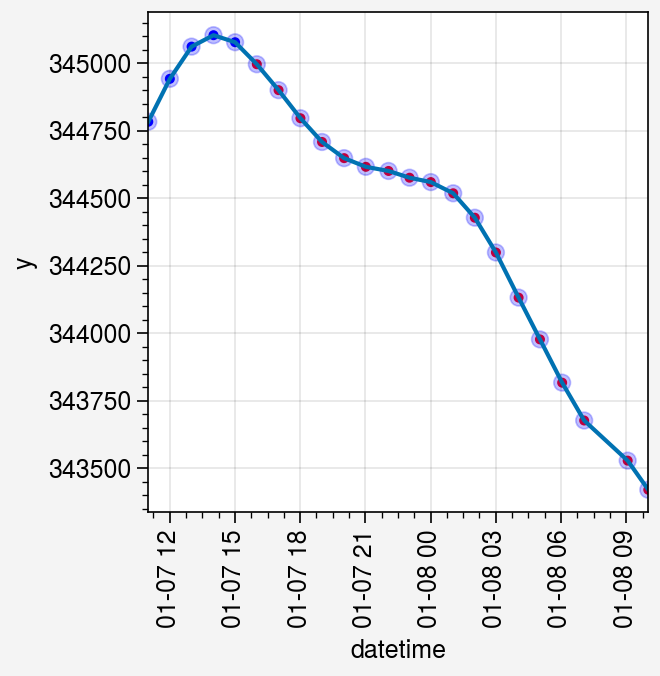

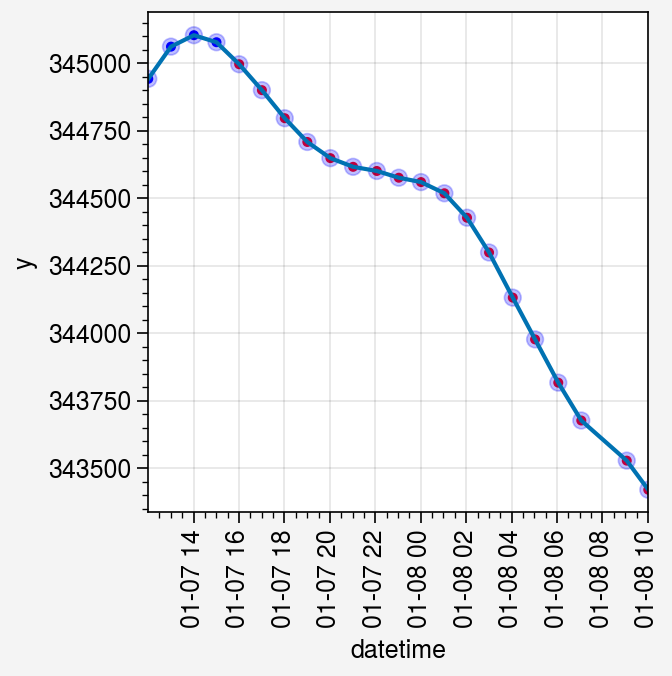

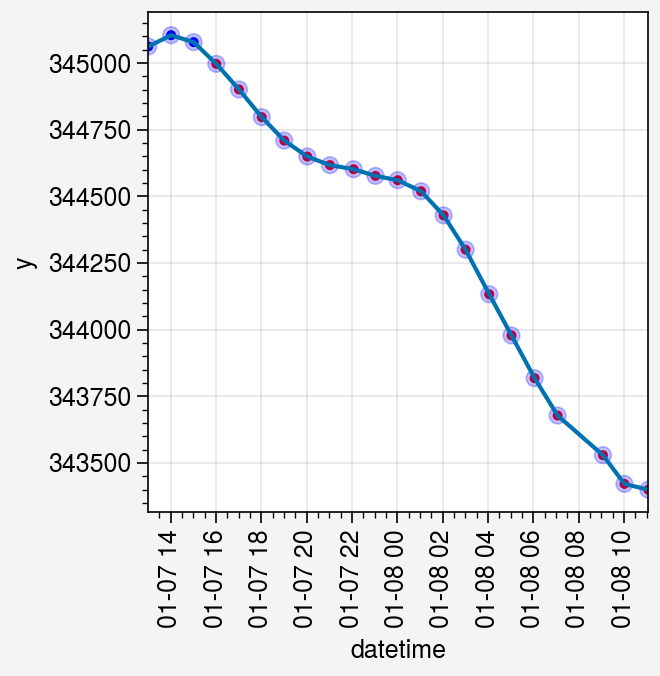

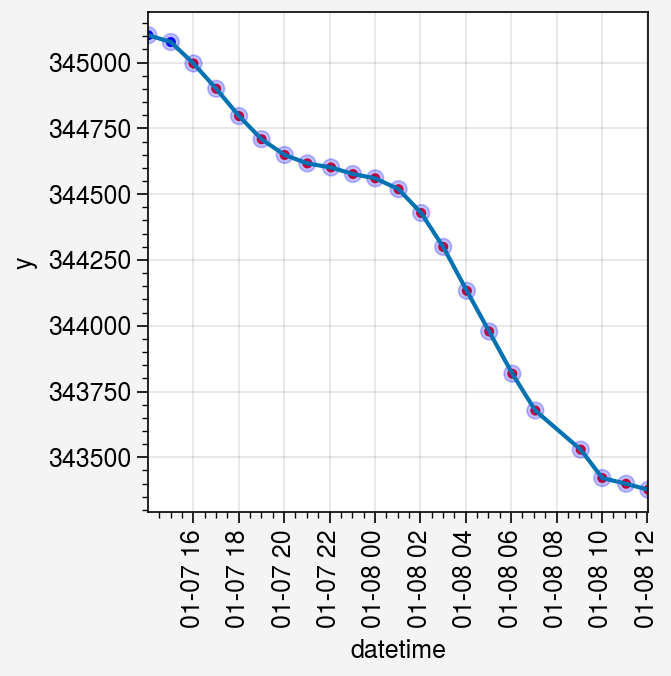

In [220]:
dates = buoy_df.index[np.abs(buoy_df['y_anom']) > 200]
for date in dates:
    timeslice = slice(date - margin, date + margin)
    fig, ax = pplt.subplots()
    ax.plot(buoy_df['y'].loc[timeslice])
    ax.scatter(buoy_df['y'].loc[timeslice],
               c=buoy_df['flag_position_spline'].loc[timeslice], marker='.', cmap='bwr')
    ax.scatter(buoy_df['y'].loc[timeslice],
               c=(np.abs(buoy_df['y_anom']) > 200).loc[timeslice], marker='o', cmap='bwr', alpha=0.25)

DatetimeIndex(['2021-01-08 15:04:03', '2021-01-08 16:04:02',
               '2021-01-08 19:03:59', '2021-01-08 20:04:01',
               '2021-02-10 04:03:59', '2021-02-10 05:04:01',
               '2021-02-18 08:04:01', '2021-03-05 12:04:03',
               '2021-03-05 13:04:04', '2021-03-30 08:04:01',
               '2021-04-09 12:04:03'],
              dtype='datetime64[ns]', name='datetime', freq=None)


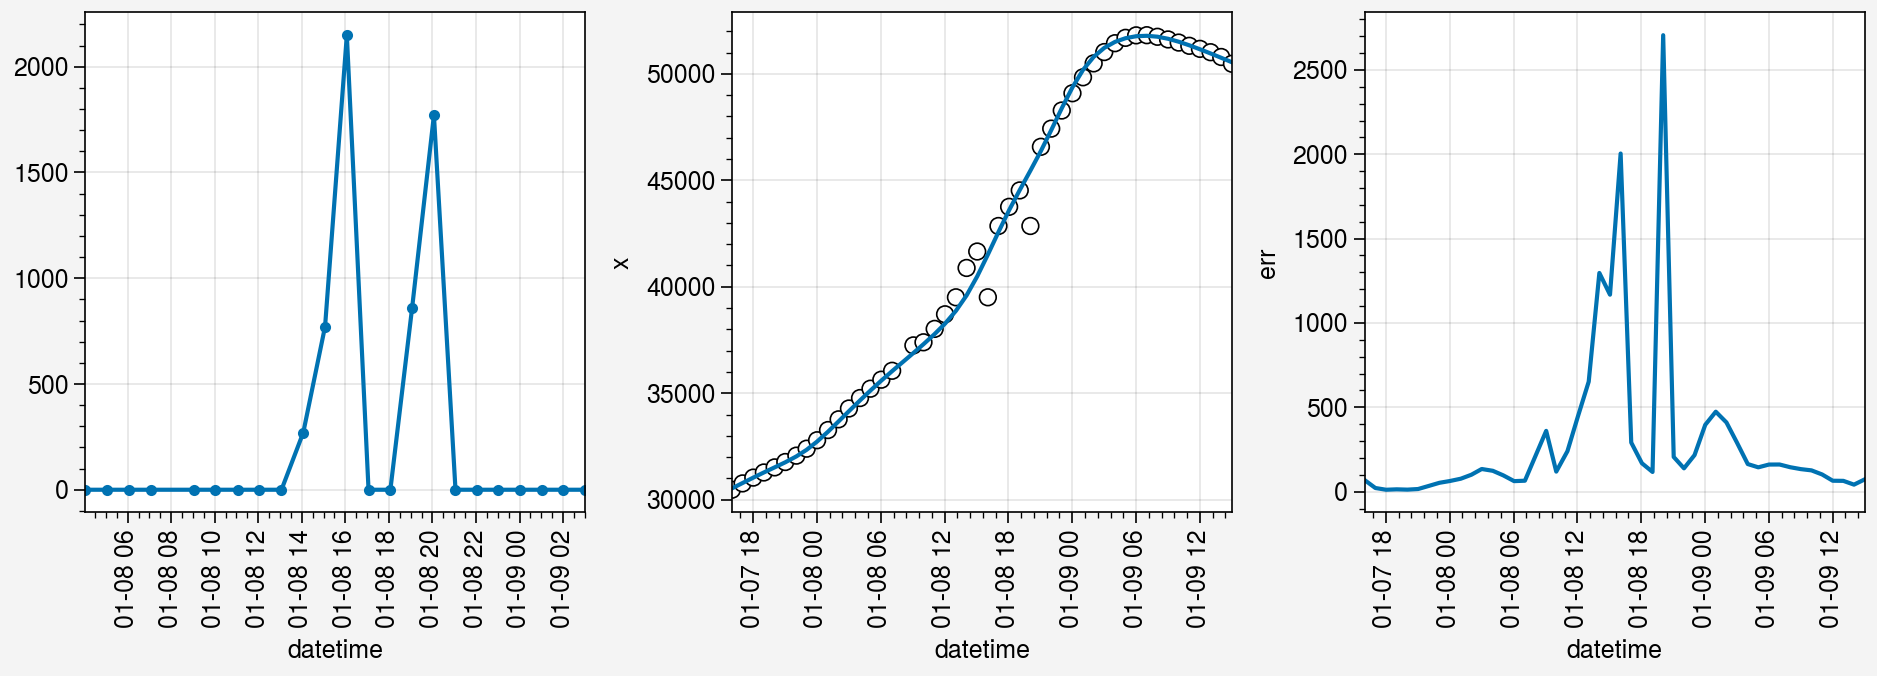

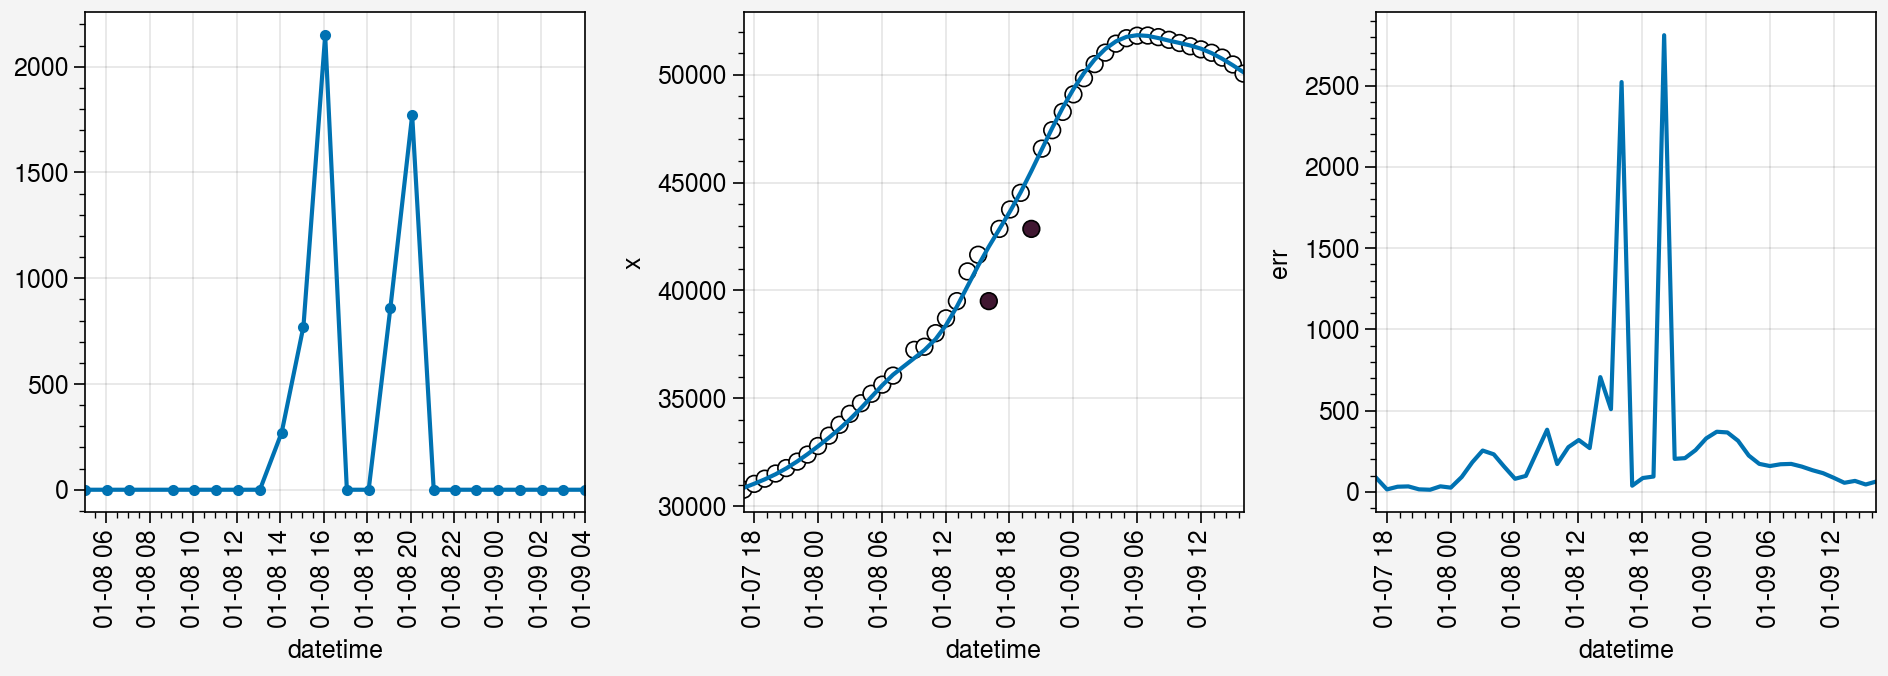

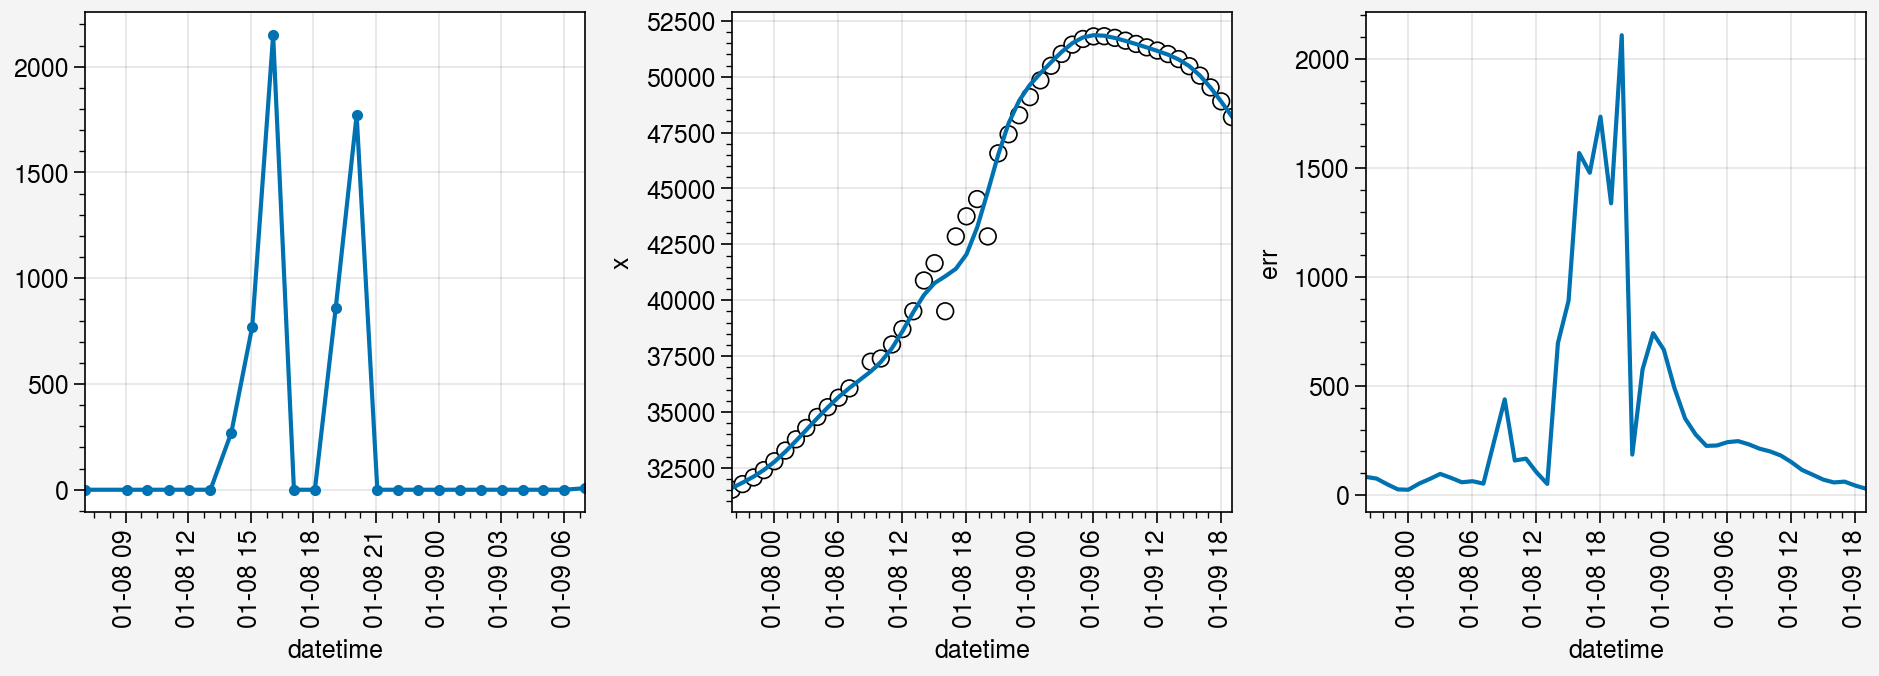

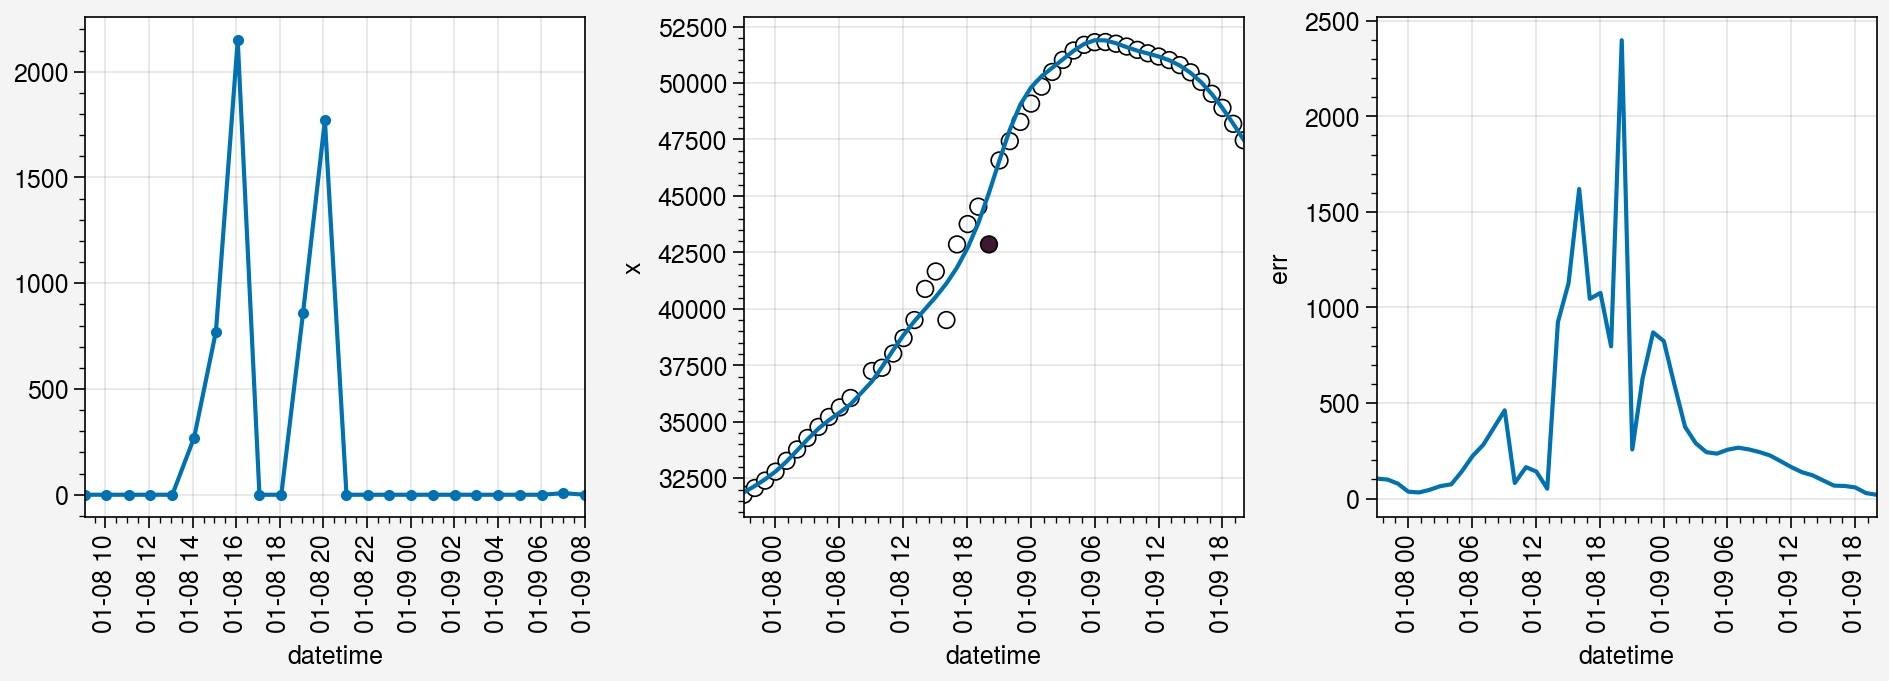

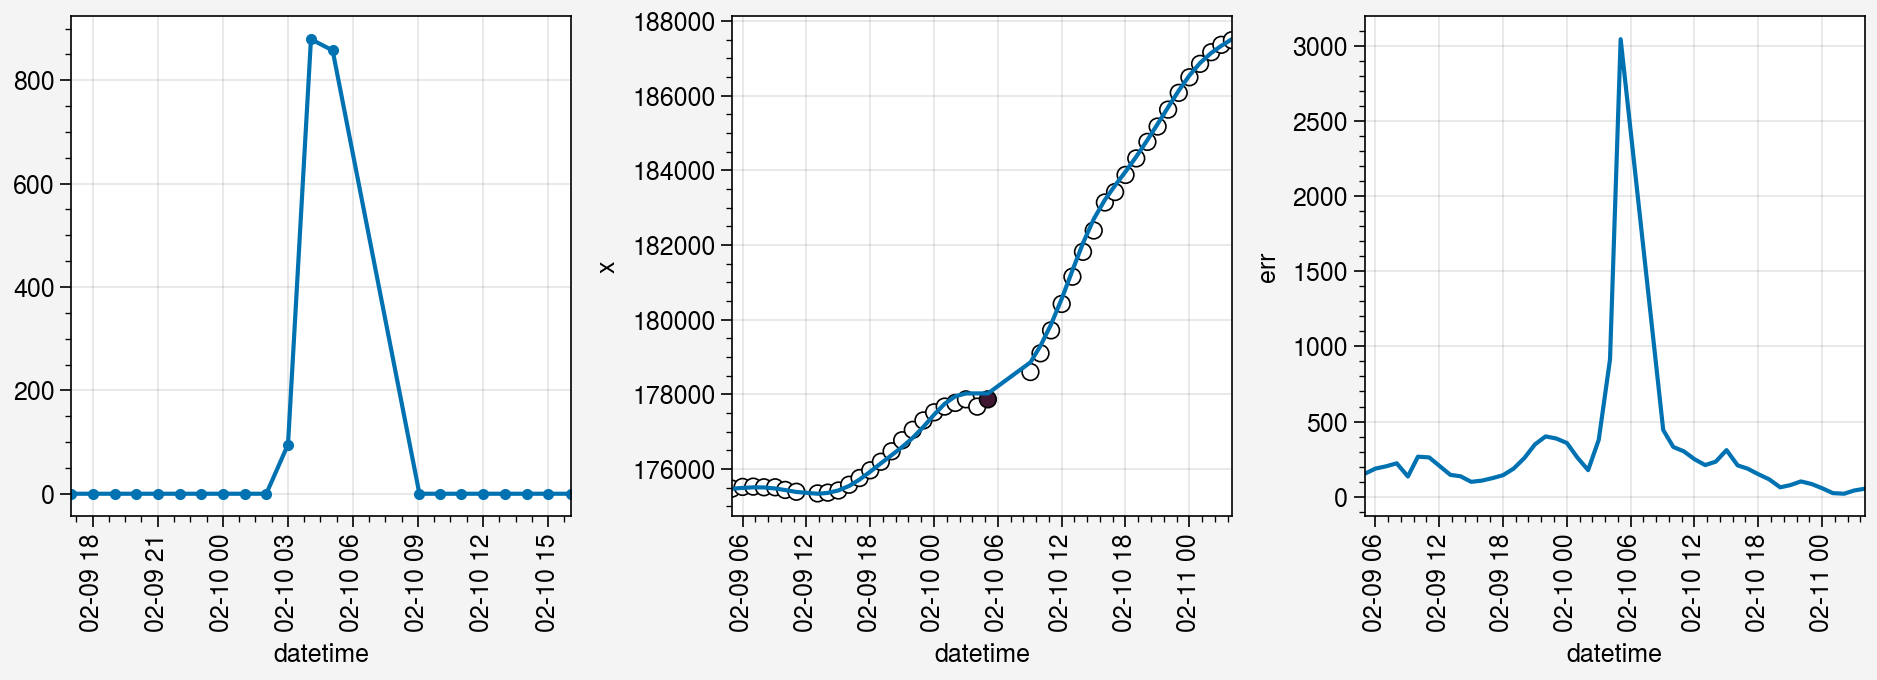

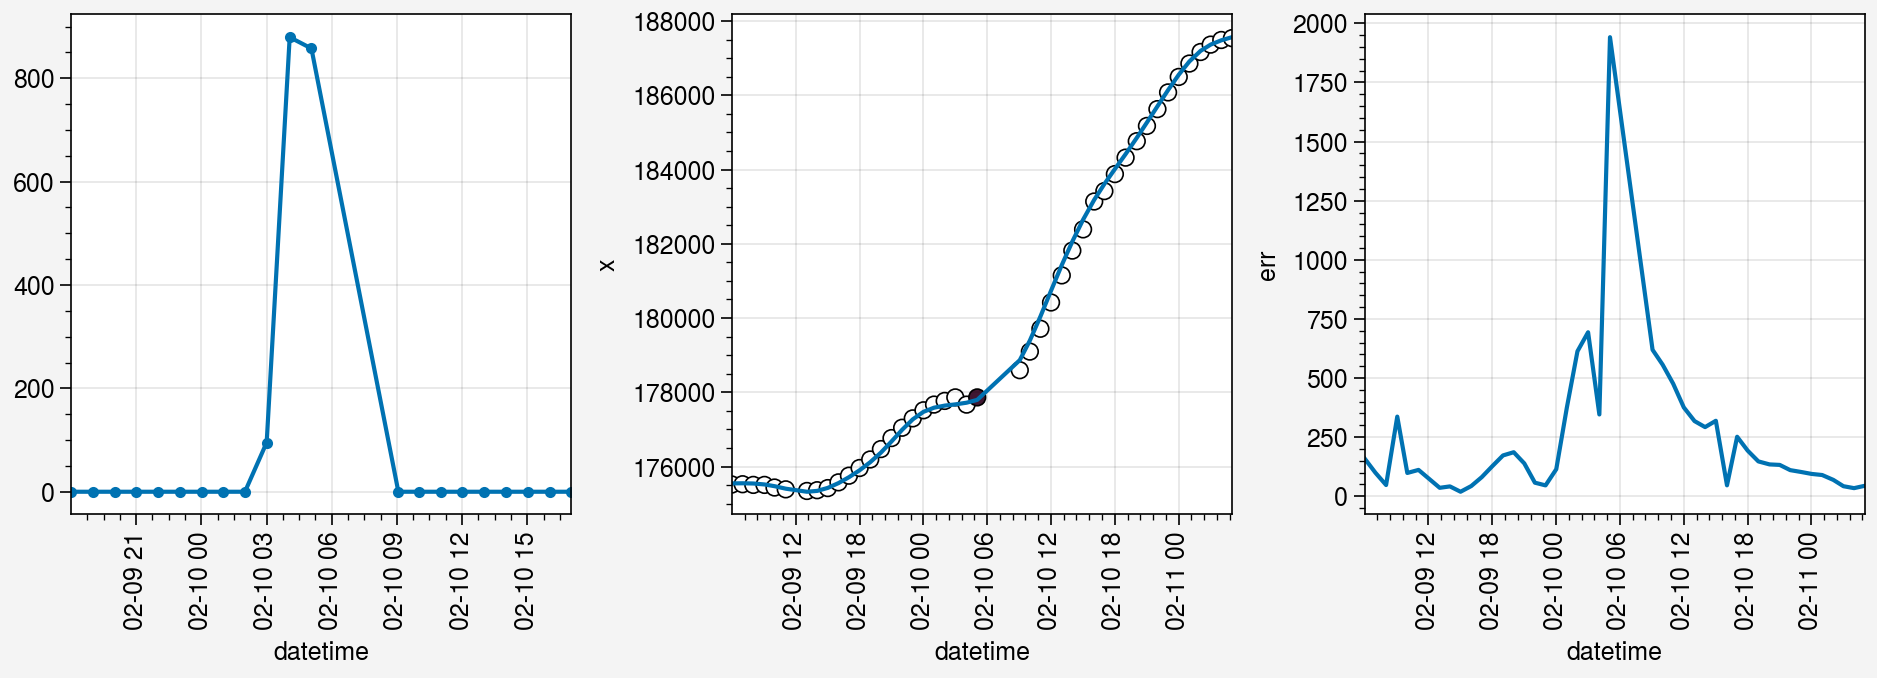

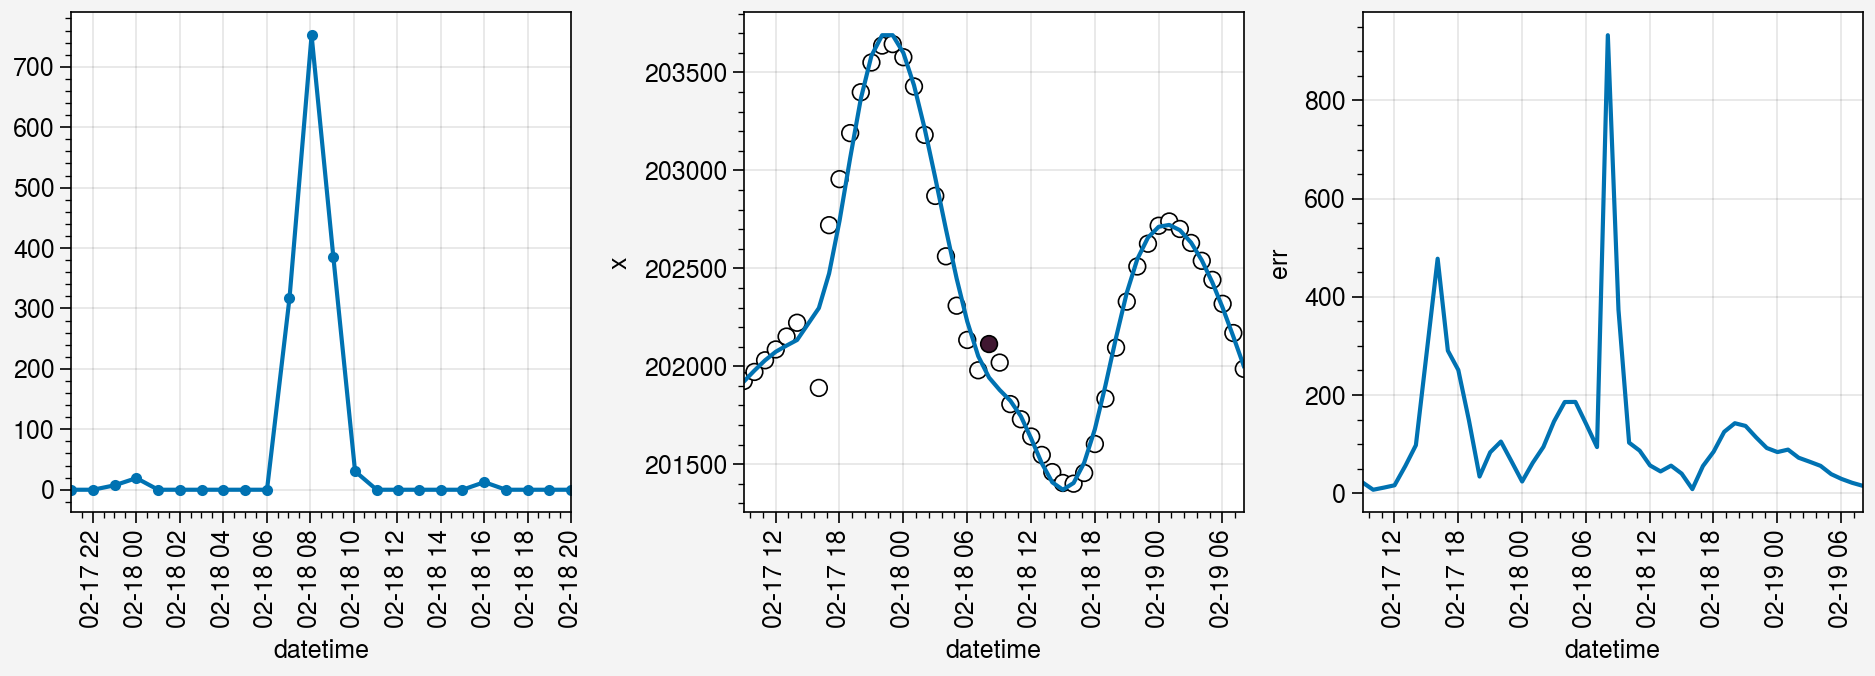

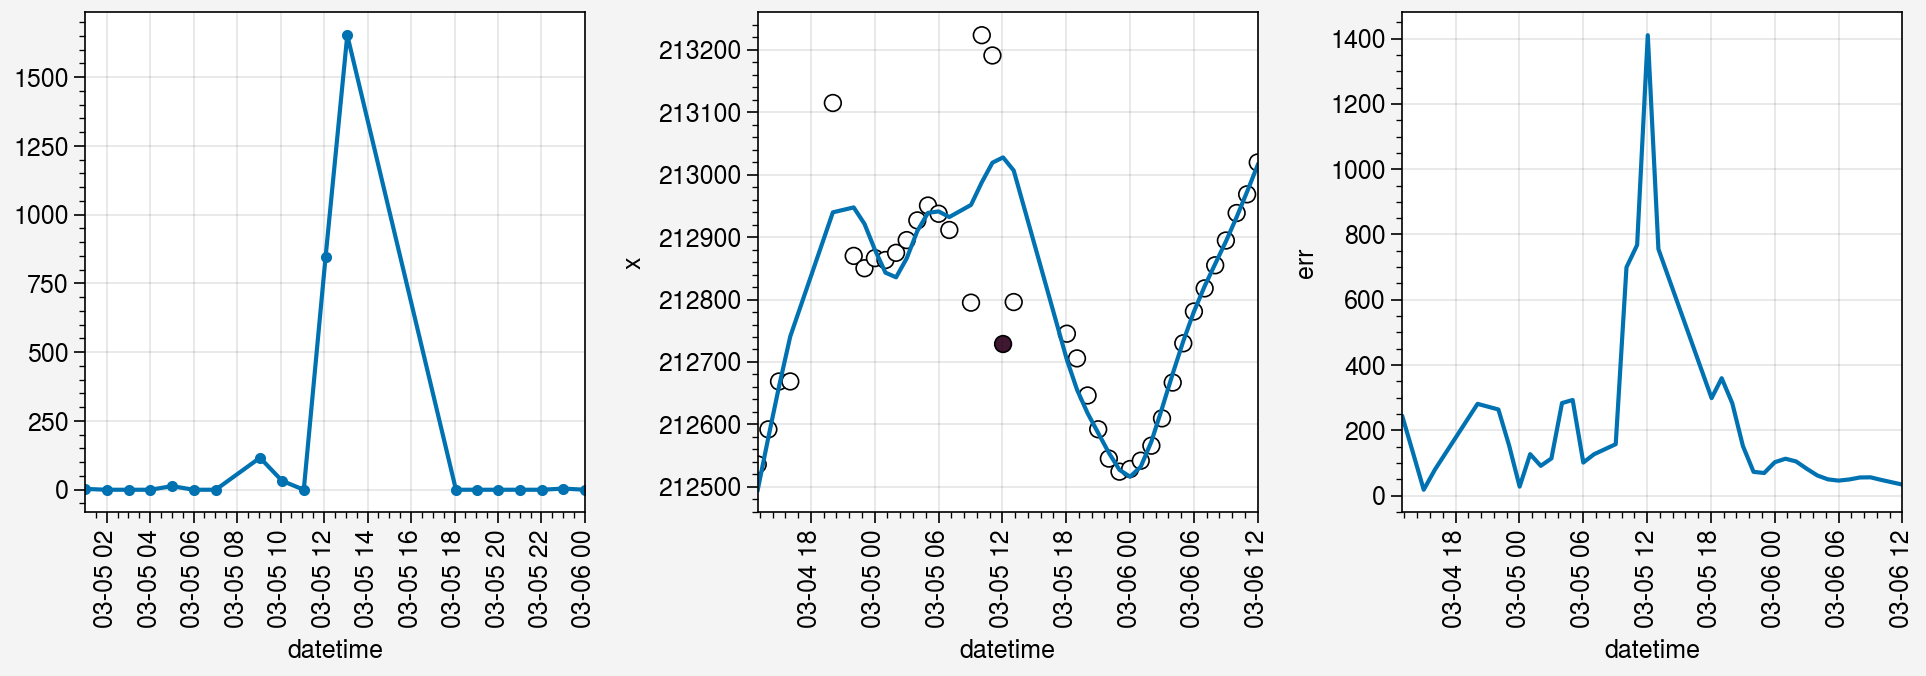

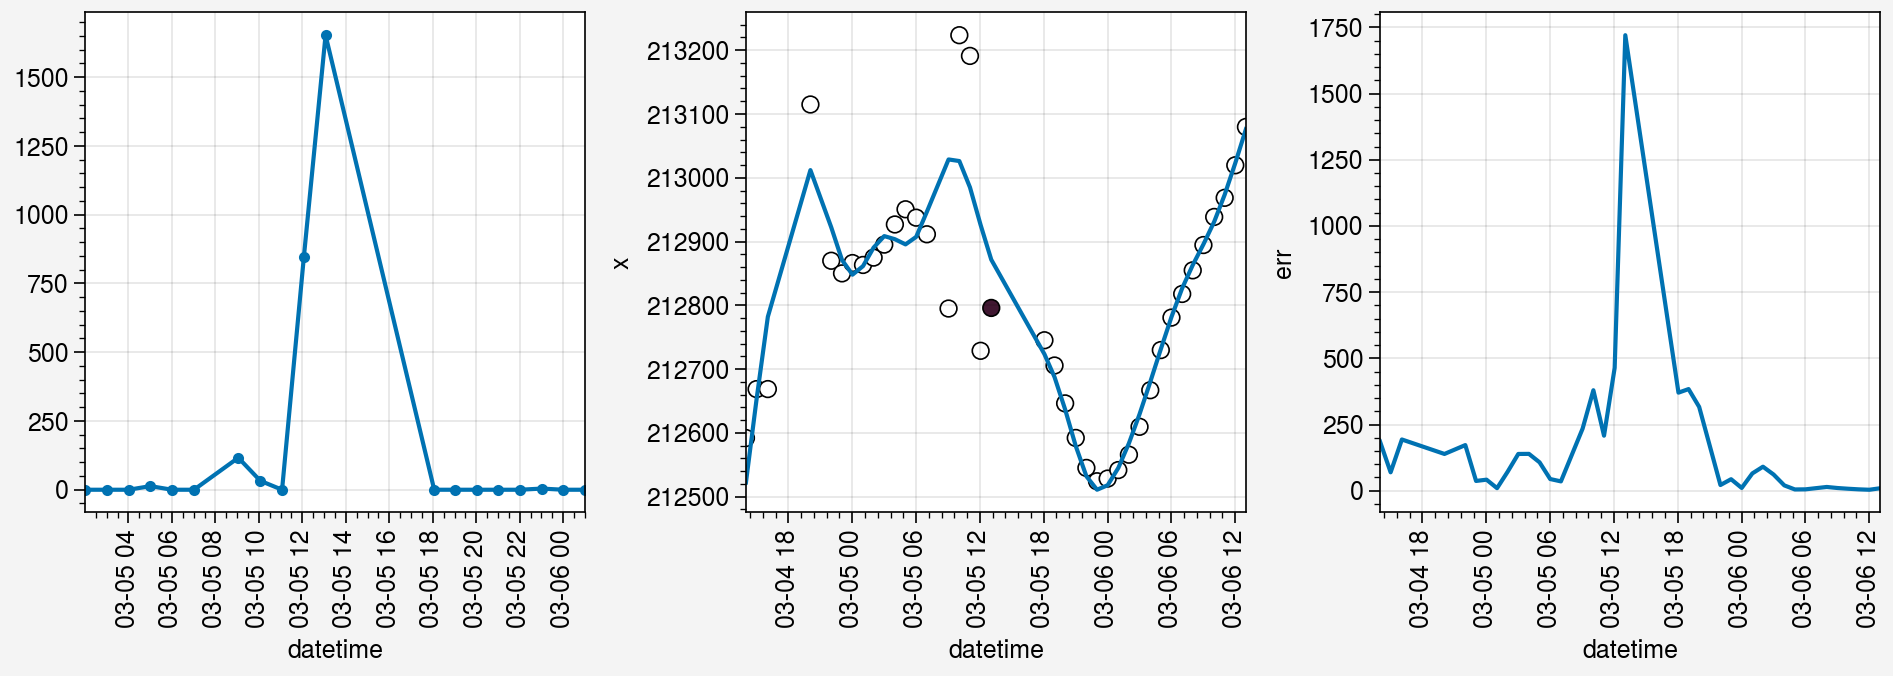

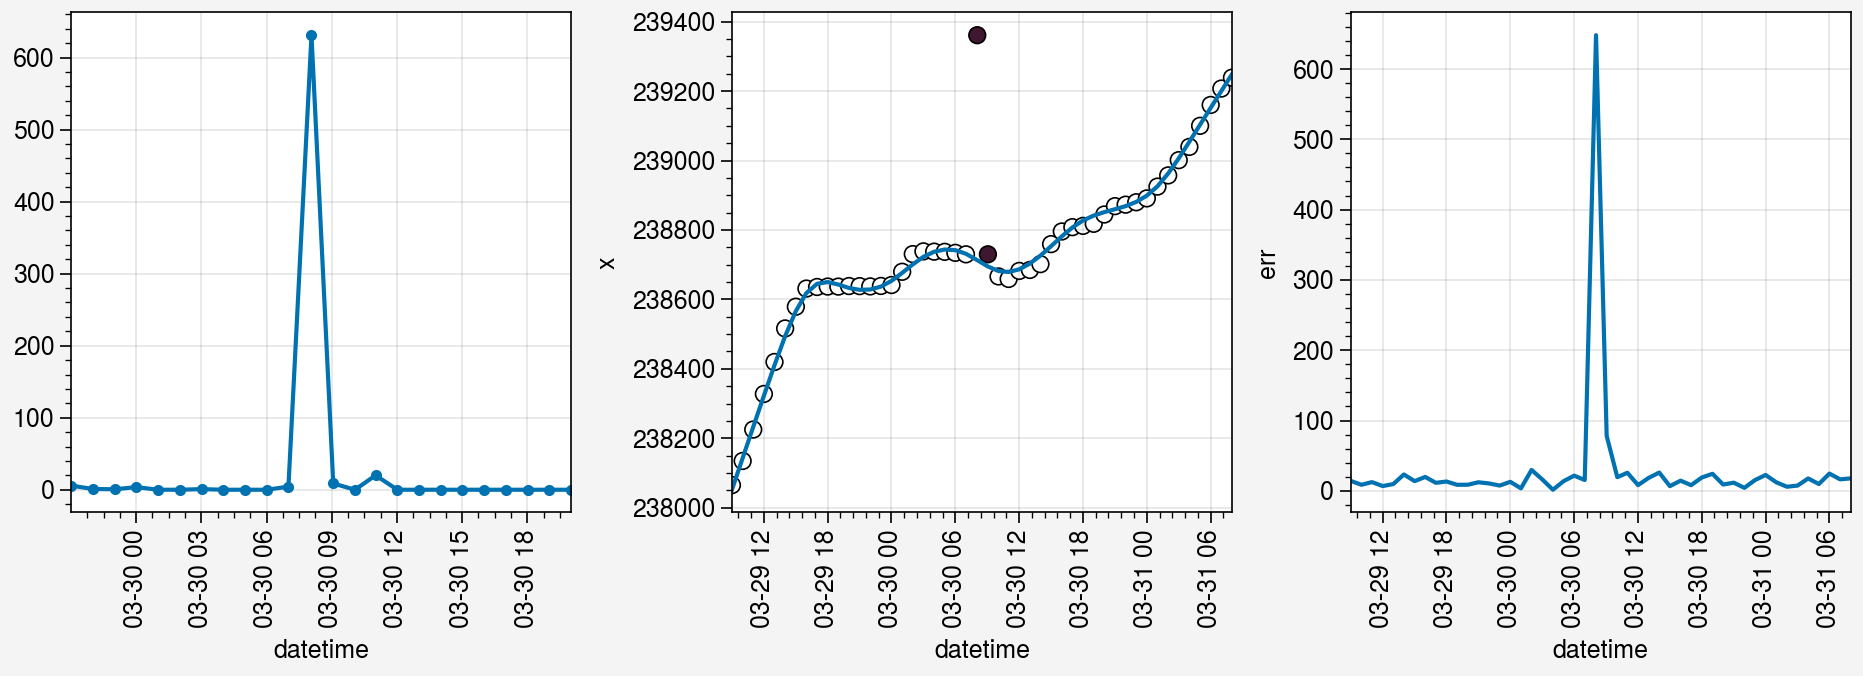

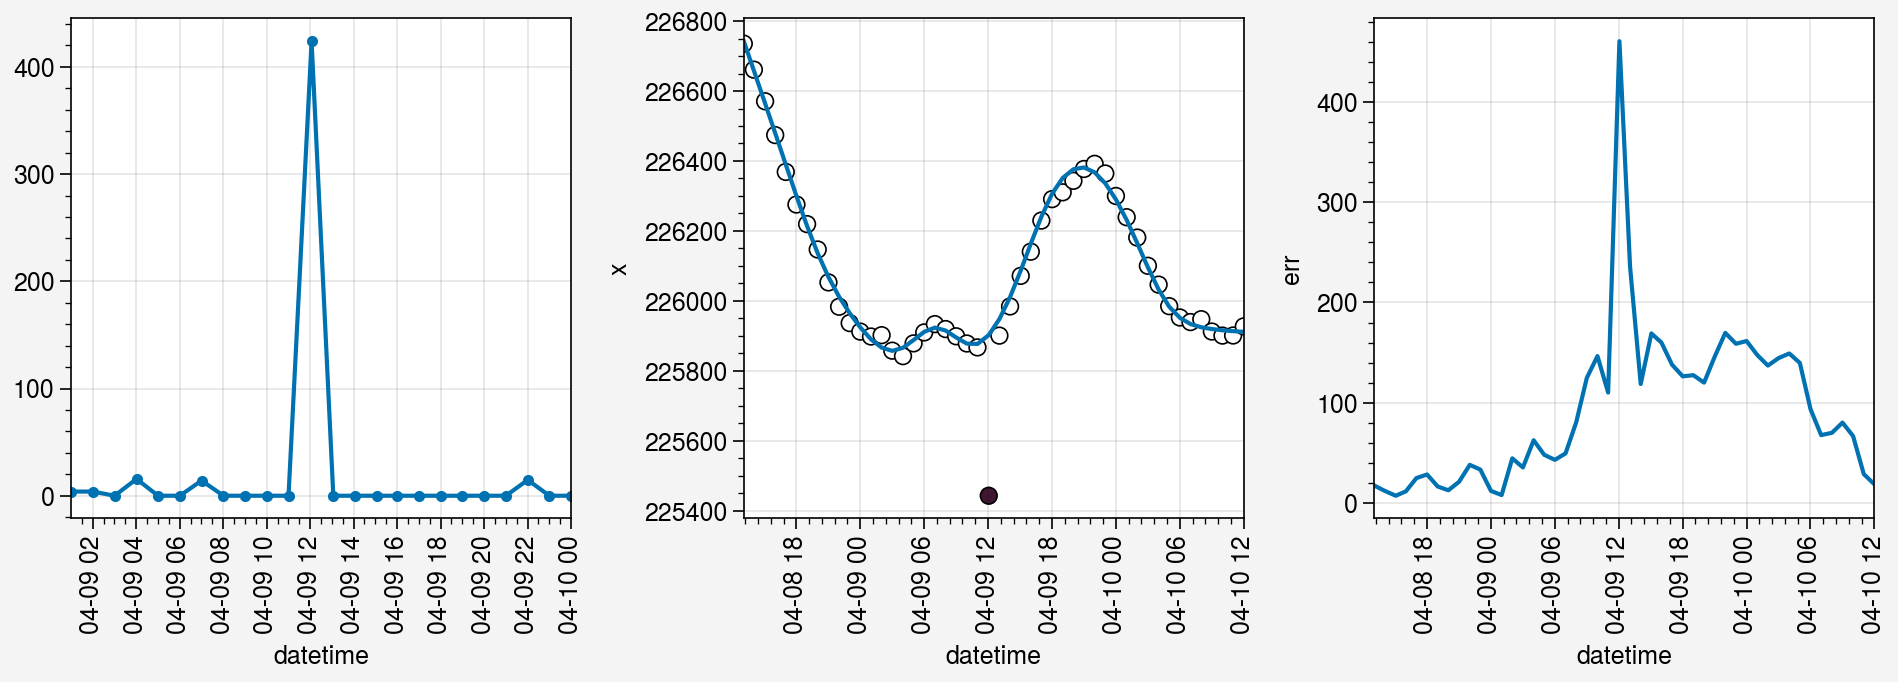

In [191]:
date = test_df.loc[2, 'date']
margin = pd.to_timedelta('12H')
buoy = test_df.loc[2, 'buoy_id']
anom_x = buoy_data[buoy].x_anom
anom_y = buoy_data[buoy].y_anom
anom = np.sqrt(anom_x**2 + anom_y**2)
buoy_data[buoy]['flag_position_spline'] = 0
print(anom[anom > 400].index)
for date in anom[anom > 400].index:
    test = clean.test_point(date, buoy_data[buoy],
                            xvar='x', yvar='y', df=13, fit_window='24H', sigma=6)
    if np.any(test.flag.notnull()):
        buoy_data[buoy].loc[test.loc[test.flag.notnull()].index, 'flag_position_spline'] = 1
                            
    fig, ax= pplt.subplots(ncols=3, share=False)
    ax[0].plot(anom.loc[slice(date-margin, date+margin)], marker='.')
    ax[1].scatter(test.x, c=test.flag.astype(int), edgecolor='k')
    ax[1].plot(test.x_hat)
    ax[2].plot(test.err)

In [41]:
fix_buoys = ['2019O3', '2019O4', '2019P102', '2019P103', '2019P105', '2019P138',
             '2019P140', '2019P142', '2019P183', '2019P203', '2019P88', '2019P91', '2019P196',
             '2019R9', '2019S96', '2019V4', '2020E3', '2020P219', '2020P220', '2020T73']
fix_buoys.sort()



In [75]:
t0 = pd.to_datetime('2019-11-01 00:00')
t = (buoy_data[buoy].index - t0).total_seconds()
x = buoy_data[buoy].longitude
y = buoy_data[buoy].latitude
# fraction used: it'd be better to have a moving window.
xhat = lowess(x, t, frac=12/len(t))

2019O3


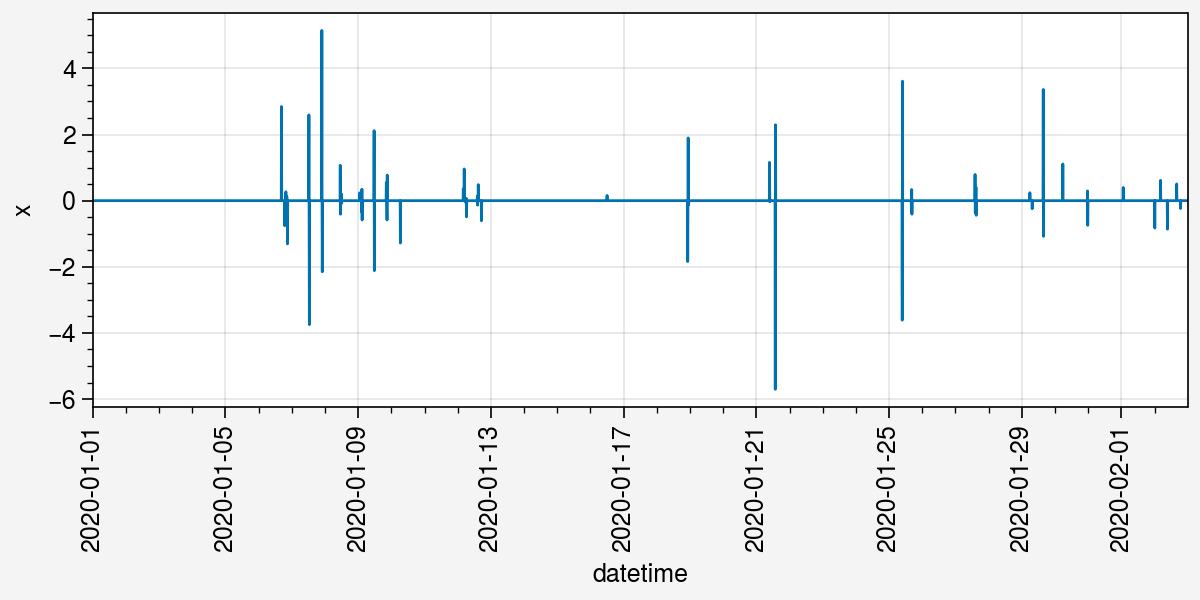

In [90]:
fig, ax = pplt.subplots(width=6, height=3)
timeslice = slice('2020-01-01', '2020-02-02')
for buoy in ['2019O3']:
    buoy_data[buoy]['flag'] = buoy_data[buoy].flag_date | buoy_data[buoy].flag_gaps
    speed = buoy_data[buoy].where(buoy_data[buoy].flag != 1)['x']
    anomaly = speed - speed.rolling(3, center=True, min_periods=3).median()
    ax.plot(anomaly.loc[timeslice], lw=1, marker='')
    if np.any(buoy_data[buoy].loc[timeslice].speed > 0.4):
        print(buoy)
#ax.format(ylim=(0, 0.6))

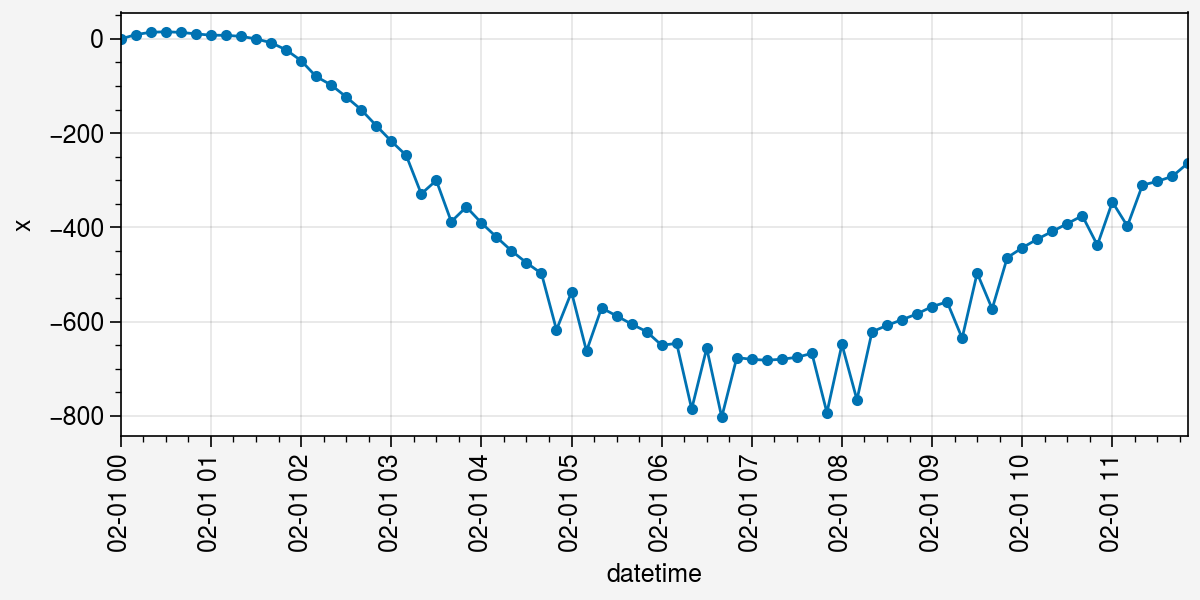

In [71]:
fig, ax = pplt.subplots(width=6, height=3)
timeslice = slice('2020-02-01', '2020-02-01 12:00')
for buoy in ['2019O3']:
    buoy_data[buoy]['flag'] = buoy_data[buoy].flag_date | buoy_data[buoy].flag_gaps
    posy = buoy_data[buoy].where(buoy_data[buoy].flag != 1)['y'].loc[timeslice]
    posx = buoy_data[buoy].where(buoy_data[buoy].flag != 1)['x'].loc[timeslice]    
    ax.plot(posx-posx.rolling('1H').median(), lw=1, marker='.')
#    if np.any(buoy_data[buoy].loc[timeslice].speed > 0.4):
#        print(buoy)
#ax.format(ylim=(0, 0.6))

<a list of 1 Line2D objects>

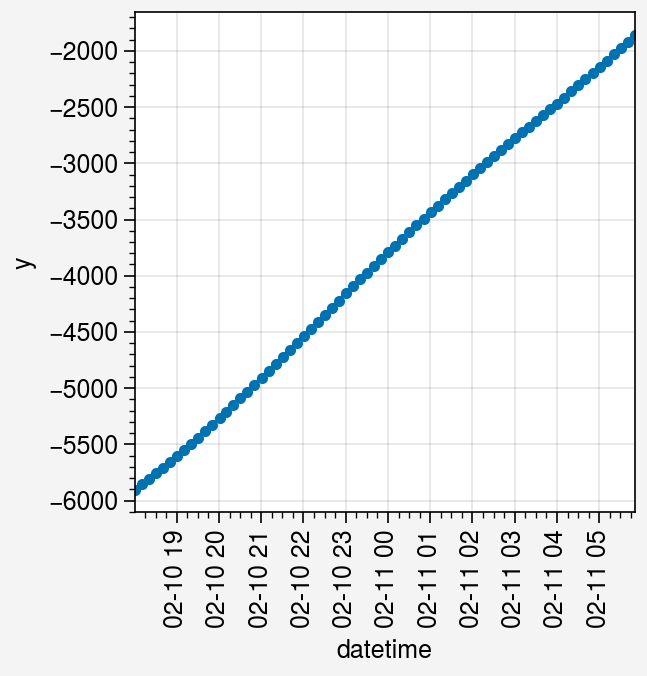

In [282]:
# Question: would interpolation with a cubic spline be faster than the check_splines method?
fig, ax = pplt.subplots()
date = pd.to_datetime('2020-02-11 00:00')
margin = pd.to_timedelta('6H')
ax.plot(#buoy_data['2019P103'].loc[slice(date-margin, date+margin)].u,
        buoy_data['2019P103'].loc[slice(date-margin, date+margin)].y, marker='.')

Removing data points with unphysical reported speeds

Problem: difficult to identify problem data points in a consistent way since the buoy data are not consistent. Tried lots of different things to clean the data, with some progress and some recurring setbacks.

Plan: One month at a time, identify buoys with clear problems

Potentially make season and latitude dependent speed thresholds
(winter: 

Potentially frequency dependent speed anomaly thresholds

In [173]:
for buoy in buoy_data:
    fwd_speed = clean.compute_speed(buoy_data[buoy].copy(), date_index=True, difference='forward')   
    bwd_speed = clean.compute_speed(buoy_data[buoy].copy(), date_index=True, difference='backward')
    speed = pd.DataFrame({'b': bwd_speed['speed'], 'f': fwd_speed['speed']}).min(axis=1)
    anomaly = speed - speed.rolling('1D', center=True, min_periods=6).mean()
    buoy_data[buoy]['flag_speed'] = anomaly > 1


In [196]:
for buoy in buoy_data:
    if buoy_data[buoy].flag_speed.sum() > 0:
        print(buoy, buoy_data[buoy].flag_speed.sum())

2019P105 2
2019P119 22
2019P151 1
2019P203 1
2019P206 1
2019R9 1
2019T70 1
2019V4 1
2020O10 7
2020P218 1
2020P225 1


In [197]:
timeslice=slice('2021-02-01', '2021-05-01')
buoy = '2019P105'


In [193]:
flagged

DatetimeIndex(['2019-12-01 15:13:59', '2019-12-06 07:10:36'], dtype='datetime64[ns]', name='datetime', freq=None)

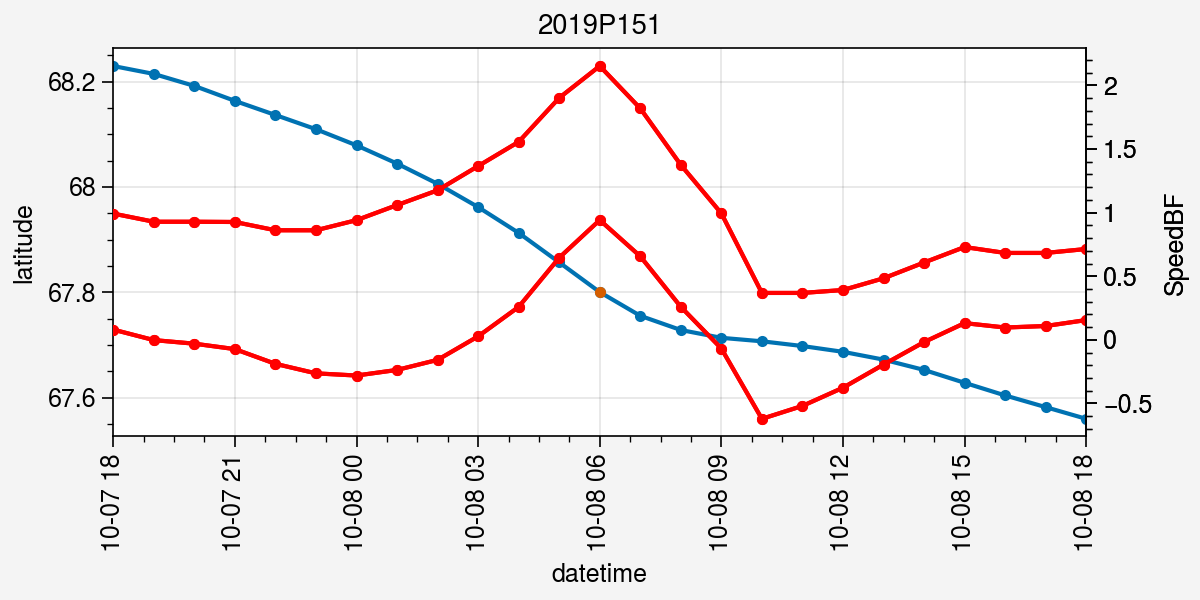

In [205]:
buoy = '2019P151'
margin = pd.to_timedelta('12H')
buoy_df = buoy_data[buoy].copy()
fwd_speed = clean.compute_speed(buoy_data[buoy].copy(), date_index=True, difference='forward')   
bwd_speed = clean.compute_speed(buoy_data[buoy].copy(), date_index=True, difference='backward')
speed = pd.DataFrame({'b': bwd_speed['speed'], 'f': fwd_speed['speed']}).min(axis=1)
anomaly = speed - speed.rolling('12H', center=True, min_periods=6).mean()

flagged = buoy_df.loc[(buoy_df.flag_speed==1)].index
if len(flagged) == 1:
    date = pd.to_datetime(flagged[0])
else:
    date = pd.to_datetime(flagged[1])

fig, ax = pplt.subplots(width=6, height=3)

buoy_df = buoy_df.loc[slice(date-margin, date+margin)]
threshold = buoy_df.rolling('12H', center=True).latitude.count()
ax.plot(buoy_df.latitude, marker='.')
ax.plot(buoy_df.where(buoy_df.flag_speed==1).latitude, marker='.', lw=0)
ax.format(title=buoy)

ax2 = ax.twinx()
ax2.plot(anomaly.loc[slice(date-margin, date+margin)], color='r', marker='.')
ax2.plot(speed.loc[slice(date-margin, date+margin)], color='r', marker='.')


ax2.format(ylabel='SpeedBF')

In [206]:

# Step one: compute dist_from_median_uv, dist_from_median_xy, distance to closest point
for buoy in buoy_data:
    data = buoy_data[buoy]
    fwd_speed = clean.compute_speed(data.copy(), date_index=True, difference='forward')   
    bwd_speed = clean.compute_speed(data.copy(), date_index=True, difference='backward')
    speed = pd.DataFrame({'b': bwd_speed['speed'], 'f': fwd_speed['speed']}).min(axis=1)
    u = pd.DataFrame({'b': np.abs(bwd_speed['u']), 'f': np.abs(fwd_speed['u'])}).min(axis=1)
    v = pd.DataFrame({'b': np.abs(bwd_speed['v']), 'f': np.abs(fwd_speed['v'])}).min(axis=1)    
    buoy_data[buoy]['speed_bf'] = speed
    buoy_data[buoy]['x'] = fwd_speed['x']
    buoy_data[buoy]['y'] = fwd_speed['y']

    check_dup = clean.flag_duplicates(data, date_index=True)
    check_dates = clean.check_dates(data, date_index=True)
    check_speed = clean.check_speed(data, date_index=True, sigma=10, window=5)

    flags = (check_dup | check_dates) | check_speed
    
    data = data.where(~flags).dropna()
    
    # Add check with the spline function
    
    if len(data.loc[slice(begin, end)]) > 30*24:        
        dt = pd.to_timedelta(np.diff(data.index)).median().seconds/3600
        if np.round(dt,1) <= max_dt:
            data_interp = interp.interpolate_buoy_track(
                data.loc[slice(pd.to_datetime(begin)-margin,
                               pd.to_datetime(end)+margin)],
                xvar='longitude', yvar='latitude', freq='1H',
                maxgap_minutes=240)
            data_interp['day_count'] = data_interp.rolling(window='1D', center=True).count()['longitude']
            data_interp = data_interp.where(data_interp.day_count >= 12).dropna()
                
            # Compute speed with interpolated data
            data_interp = clean.compute_speed(
                data_interp, date_index=True, rotate_uv=True, difference='centered').loc[slice(begin, end)]
            
            # Write to file
            data_interp.to_csv(saveloc + metadata.loc[buoy, 'filename'] + '.csv')
            
        else:
            print(buoy, dt, 'Frequency too low')
    else:
        print(buoy, 'Insufficient data after dup/date/speed check: ', len(data))

KeyboardInterrupt: 